This notebook performs all post-processing of allelic data that is included in the paper regarding scRNA-seq allelic kinetics of XCR (not XCU)  

The input data is the matrix generated by Bart in notebooks: Adrian_Allele_specific_preproc and Adrian_allele_specific_analysis_zeros_included_norm  
  
Here, I will import the final matrix with normalized allelic ratios

In [1]:
setwd("/staging/leuven/stg_00041/Adrian/TALON_JANISZEWSKI_XCR2/")

In [2]:
suppressPackageStartupMessages({
    library(Seurat)
    library(dplyr)
    library(readr)
    library(ggplot2)
    library(tidyr)
    library(tibble)
    suppressMessages(library(viridis))
})

Warning message:
"package 'Seurat' was built under R version 3.6.2"

In [3]:
allelic <- read_csv("allele_specific/pre_processing/AJ_0065.9c_allelic_norm_complete.csv")

Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_double(),
  gene = col_character(),
  RNA_id = col_character(),
  X = col_double(),
  X129 = col_double(),
  Cast = col_double(),
  sumReads = col_double(),
  ratioPercent = col_double(),
  ratioLog = col_double(),
  Pseudotime = col_double(),
  seurat_clusters_rename = col_double(),
  Timepoint = col_character(),
  Xi = col_character(),
  Chr = col_character(),
  total_reads = col_double(),
  mus_norm = col_double(),
  cast_norm = col_double(),
  ratio_norm = col_double(),
  sum_norm = col_double()
)


In [5]:
allelic <- allelic %>% 
                rename("cluster_replace" = "seurat_clusters_rename")

In [6]:
# For later create a mapping table of RNA_id:cell_type:cluster_replace

mapping <- allelic %>%
                select(RNA_id, cluster_replace) %>%
                group_by(RNA_id) %>%
                distinct()

consistent_cluster <- allelic %>% filter(sumReads > 10, Chr == "chrX") %>%
                                group_by(cluster_replace, gene) %>%
                                distinct(gene) %>%
                                ungroup() %>%
                                count(gene) %>%
                                filter(n >= 6) %>%
                                select(gene)

In [8]:
genes_kinetics <- read_csv2("allele_specific/XCR/AJ_31_genes_by_kinetics.csv")

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.
Parsed with column specification:
cols(
  Escapees = col_character(),
  Early = col_character(),
  Intermediate = col_character(),
  Late = col_character(),
  `Very late` = col_character()
)


In [9]:
kinetics <- genes_kinetics %>% gather(kinetic, gene)
kinetics$kinetic <- factor(kinetics$kinetic, levels = c('Early','Intermediate','Late','Very late' , 'Escapees'))

In [10]:
allelic_kin <- merge(allelic, kinetics, by="gene")

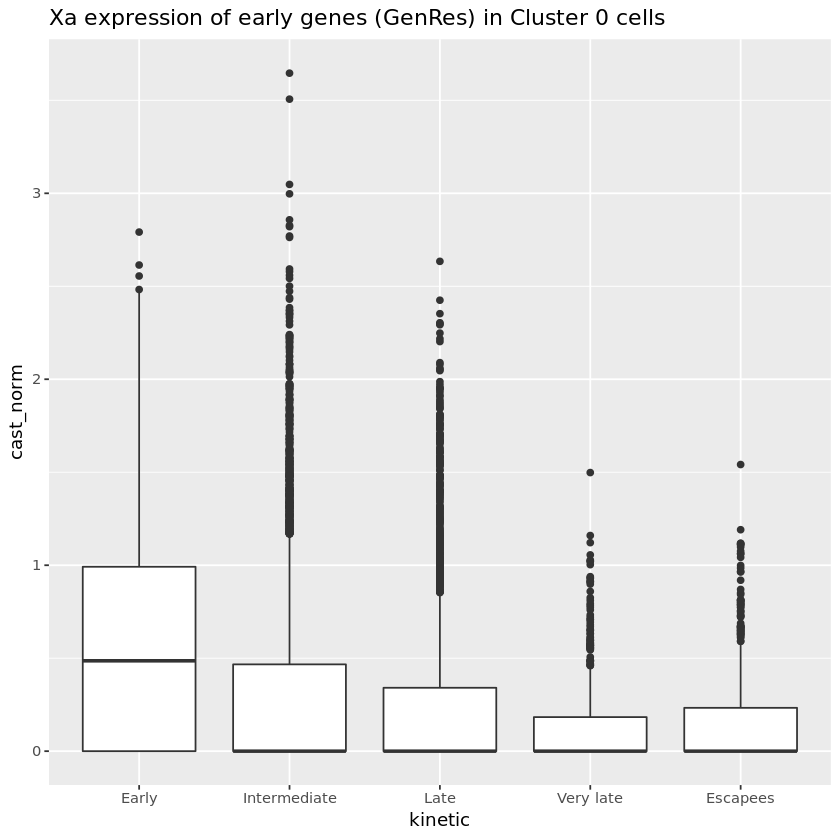

In [11]:
allelic_kin %>% 
    filter(Chr == "chrX", cluster_replace == 0) %>%
        ggplot(aes(kinetic, cast_norm)) +
            geom_boxplot()+
            ggtitle("Xa expression of early genes (GenRes) in Cluster 0 cells")

In [9]:
chrX <- allelic_kin %>% filter(Chr=="chrX" & sumReads >= 1) %>% select(gene,RNA_id,mus_norm,cast_norm,cluster_replace, ratio_norm, kinetic) %>% 
        group_by(cluster_replace, RNA_id, kinetic) %>%
        summarize(mean_ratio = mean(ratio_norm))

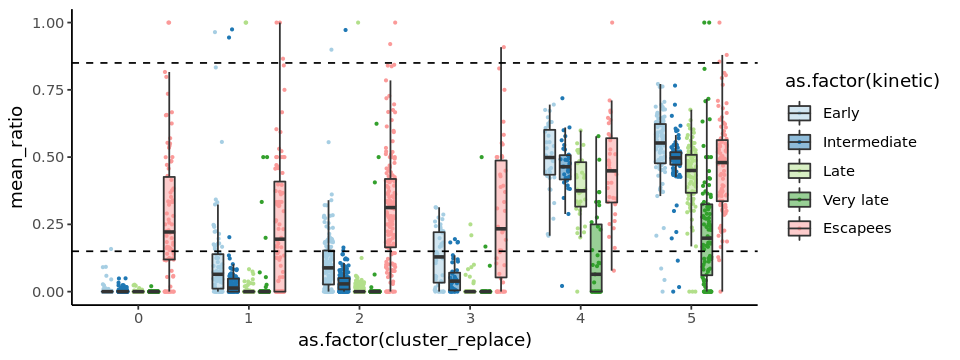

In [10]:
options(repr.plot.width=8, repr.plot.height=3)
kinetics_plot <- ggplot(chrX, aes(as.factor(cluster_replace), mean_ratio)) +
                                                     geom_point(aes(color = as.factor(kinetic)),
                                                                  position = position_jitterdodge(jitter.width = .3, dodge.width=.7),
                                                                  size = .5) +
                                                     geom_boxplot(aes(fill = as.factor(kinetic)), 
                                                                  outlier.colour = NA, 
                                                                  position=position_dodge(0.7),
                                                                  width = .5,
                                                                  alpha = .5)+
                                                     geom_hline(yintercept = c(0.15, 0.85), linetype = 'dashed', size = .5) +
                                                #     coord_cartesian(ylim = c(0,1))+
                                                     scale_color_brewer(palette = "Paired")+
                                                     scale_fill_brewer(palette = "Paired")+
                                                     # coord_flip()+

                                                        theme_classic() 
kinetics_plot                                            

In [31]:
#setwd("/ddn1/vol1/staging/leuven/stg_00041/Bart/Exp2/Data/RNA/Figures")
#pdf(paste0("Adrian_kinetics_after_normalisation.pdf"), useDingbats = FALSE, height=5, width=10)
#kinetics_plot
#dev.off()

png 
  2

### Plotting along pseudotime

In [11]:
plot_subsetAlongPseudo <- function(data, subset){
    plot <- allelic %>% 
        filter(gene %in% consistent_cluster$gene, gene %in% subset) %>% 
        group_by(X129, Cast, sumReads, RNA_id, Pseudotime, cluster_replace) %>% 
        summarize(mean_mus = mean(mus_norm), mean_cast = mean(cast_norm) , meanX = mean(ratio_norm)) %>%                         
            ggplot(aes(Pseudotime, log2(meanX))) +
                geom_point(size = 1, alpha = 1, aes(color = cluster_replace)) +
                geom_smooth(color = "black", size = .7) +                                                     
                geom_hline(yintercept = c(0.15, 0.85), linetype = 'dashed', size = .5) +
                                                    # coord_cartesian(ylim = c(0,1))+
                ggtitle(paste0(subset)) + 
                theme_classic()   
                                return(plot)
                                        }

In [12]:
kin <- colnames(genes_kinetics)
plots <- list()
for(i in 1:length(kin)){
subset <- genes_kinetics %>% select(i)
plots[[i]] <- allelic_kin %>% 
        filter(gene %in% consistent_cluster$gene, kinetic == kin[i] & sumReads >= 1) %>% 
        group_by(RNA_id, Pseudotime, cluster_replace) %>% 
        summarize(mean_mus = mean(mus_norm), mean_cast = mean(cast_norm) , mean_ratio = mean(ratio_norm)) %>%                         
            ggplot(aes(Pseudotime, mean_ratio)) +
                geom_point(size = 1, alpha = 1, aes(color = as.factor(cluster_replace))) +
                geom_smooth(color = "black", size = .7) +                                                     
                geom_hline(yintercept = c(0.15, 0.85), linetype = 'dashed', size = .5) +
                                                     coord_cartesian(ylim = c(0,1))+
                ggtitle(paste0(kin[i], ", cells: ")) +
                theme_classic()   
}

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


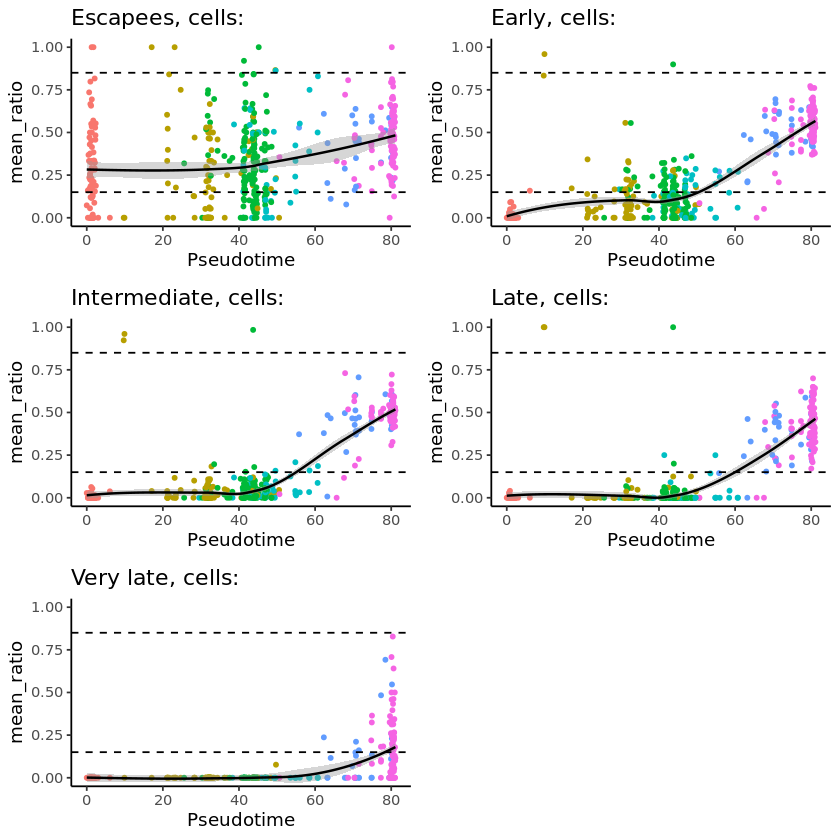

In [13]:
options(repr.plot.width=7, repr.plot.height=7)
CombinePlots(plots = plots, ncol=2, legend="none")

### Define de novo kinetics of X reactivation by single cells per cluster 

In [14]:
head(allelic)

X1 gene          RNA_id           X       X129 Cast sumReads ratioPercent
1 1  0610009B22Rik Day_10_Xi_Mus_59 2323152 0    0    0            NA      
2 2  0610009B22Rik Day_10_Xi_Mus_15 1559376 0    0    0            NA      
3 3  0610009B22Rik Day_10_Xi_Mus_55 2259504 0    4    4        0.0001      
4 4  0610009B22Rik Day_12_Xi_Mus_85 5823792 1    7    8        0.1251      
5 5  0610009B22Rik Day_12_Xi_Mus_87 5855616 0    0    0            NA      
6 6  0610009B22Rik Day_9_Xi_Mus_26  7765056 4    0    4        1.0001      
  ratioLog   Pseudotime ... Xi  X2  cluster cluster_replace Chr   total_reads
1         NA 43.62880   ... Mus 226 0       2               chr11  88329     
2         NA 48.75234   ... Mus  58 4       3               chr11  10125     
3 -13.287712 44.71111   ... Mus 222 0       2               chr11 115942     
4  -2.806345 32.38629   ... Mus 397 1       1               chr11 142685     
5         NA 79.94168   ... Mus 391 5       4               chr11 202247     
6        Inf 46.96879   ... Mus  11 0       2               chr11 181032     
  mus_norm   cast_norm ratio_norm sum_norm 
1 0.00000000 0.0000000        NA  0.0000000
2 0.00000000 0.0000000        NA  0.0000000
3 0.00000000 0.2963941 0.0000000  0.2963941
4 0.06773757 0.3991728 0.1450762  0.4669104
5 0.00000000 0.0000000        NA  0.0000000
6 0.19963368 0.0000000 1.0000000  0.1996337

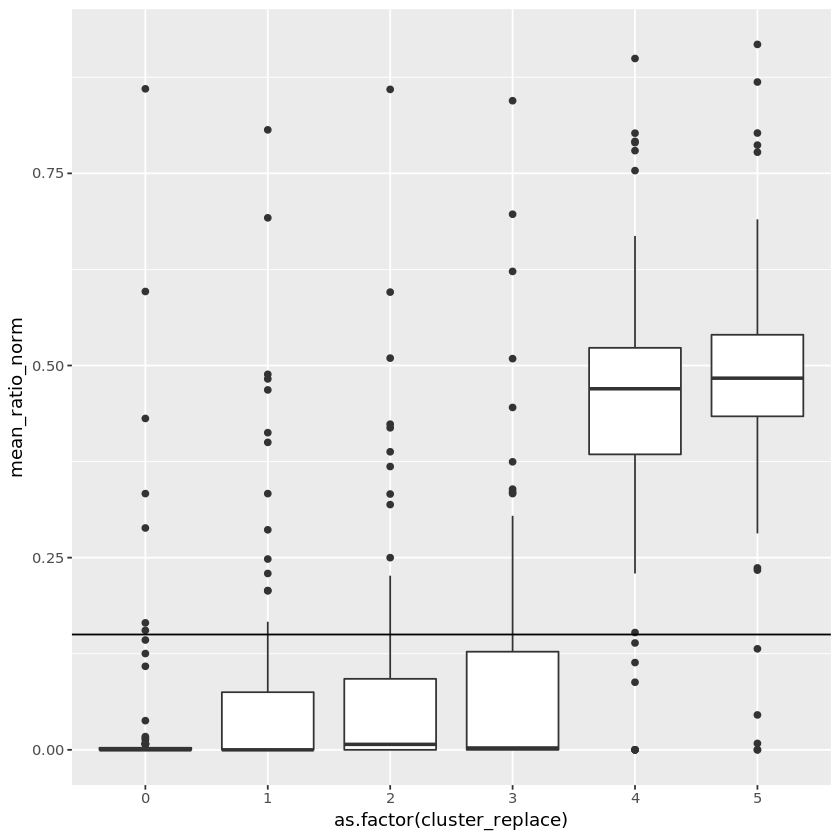

In [15]:
allelic_cluster_avg <- allelic %>% select(RNA_id, gene, Chr, cluster_replace, sumReads, ratio_norm) %>%
            filter(gene %in% consistent_cluster$gene, 
                   sumReads > 10,
                  Chr == "chrX") %>% 
            group_by(cluster_replace, gene) %>%
            summarize(mean_ratio_norm = mean(ratio_norm)) %>% ungroup() 

allelic_cluster_avg %>%
            ggplot(aes(as.factor(cluster_replace), mean_ratio_norm)) +
                    geom_boxplot() +
                    geom_hline(yintercept = 0.15)

In [16]:
library(tibble)
allelic_cluster_avg_wide <- allelic_cluster_avg %>% 
                                filter(gene != "Xist") %>%
                                spread(gene, mean_ratio_norm) %>% 
                                column_to_rownames("cluster_replace") %>%
                                t()
                               

In [17]:
# Compute k-means with k = 6
set.seed(123)
km.res <- kmeans(allelic_cluster_avg_wide, 5,iter.max = 100, nstart = 100)

In [18]:
allelic_cluster_avg_kmeans <- cbind(allelic_cluster_avg_wide, k_means_cluster = km.res$cluster) %>% 
                                as.data.frame() %>%
                                rownames_to_column("gene")

In [19]:
allelic_cluster_avg_kmeans_long <- allelic_cluster_avg_kmeans %>%
                                    gather(cluster_replace, mean_ratio_norm,-gene, -k_means_cluster) 

In [20]:

kinetics_k_plots <- list()

for (i in seq(unique(allelic_cluster_avg_kmeans_long$k_means_cluster))){
    
kinetics_k_plots[[i]] <- allelic_cluster_avg_kmeans_long %>% filter(k_means_cluster == i) %>%
                            ggplot(aes(cluster_replace, mean_ratio_norm, group = gene, color = gene)) +
                                geom_line() +
                                geom_hline(yintercept = c(0.15, 0.85), linetype = 'dashed', size = .5) +
                                                                             coord_cartesian(ylim = c(0,1))+
                                ylab("Mean allelic ratio")+
                                xlab("Cell cluster") +
                                theme_bw()
                                
    }



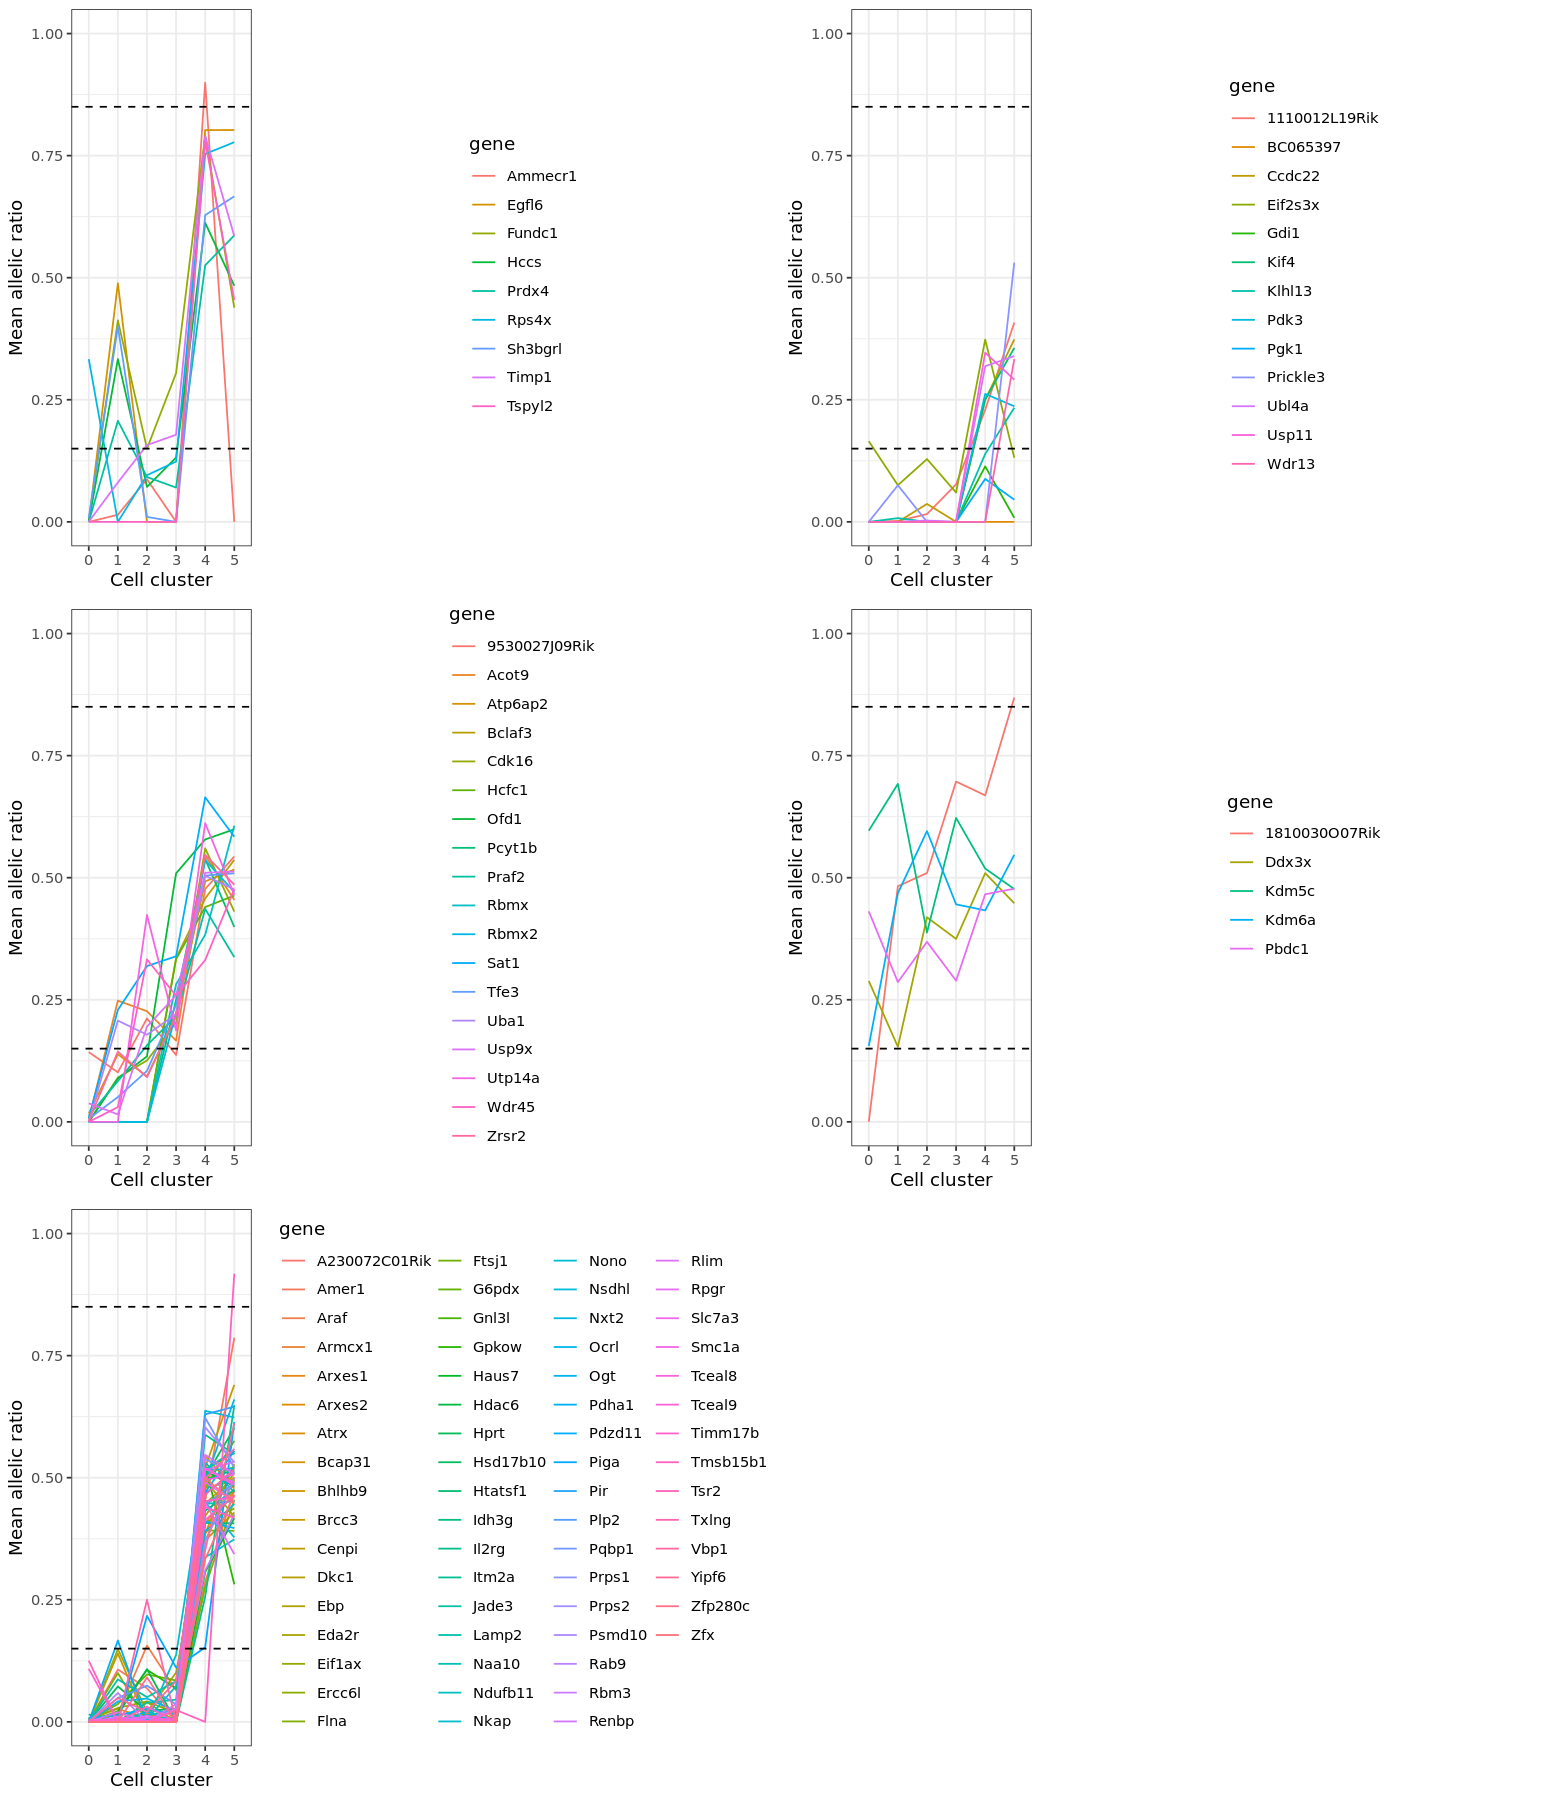

In [21]:
options(repr.plot.width=13, repr.plot.height=15)
CombinePlots(plots = kinetics_k_plots, ncol=2)

### Plot XCR kinetics as a heatmap (columns clusters, rows genes)

In [22]:
allelic_cluster_avg_kmeans_long$k_means_cluster <- factor(allelic_cluster_avg_kmeans_long$k_means_cluster, levels = c(4,1,3,5,2))

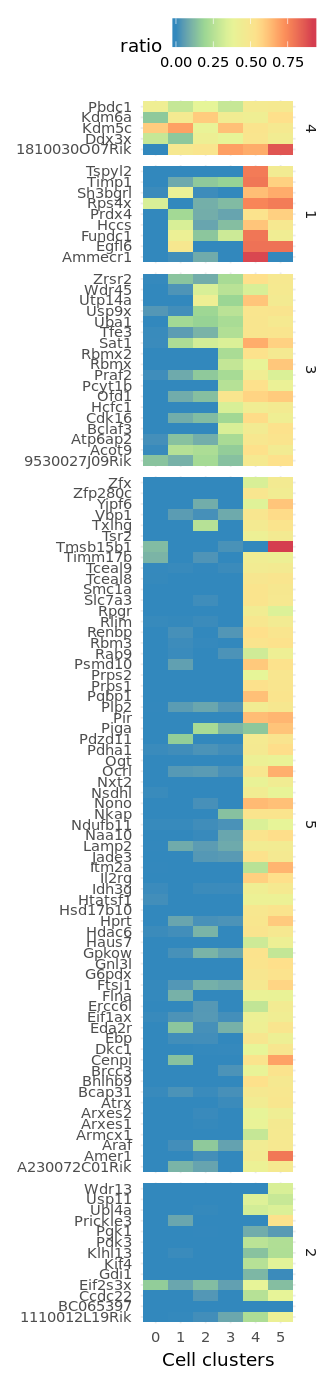

In [23]:
options(repr.plot.width=2.8, repr.plot.height=11.5)


allelic_cluster_avg_kmeans_long %>% 
            ggplot(aes(x = as.factor(cluster_replace), y = gene, fill = mean_ratio_norm)) +
                geom_tile() +
                facet_grid(k_means_cluster ~ ., scales = 'free', space = 'free_y') +
                #facet_wrap(. ~ k_means_cluster, scales="free_y", ncol = 1, strip.position = "right") +
                scale_fill_distiller(palette = "Spectral") +
                labs(x="Cell clusters", fill = "ratio") +
                
                theme_minimal()  +
                theme(legend.position = "top") +
                #theme(axis.text.y=element_blank()) +
                #theme(strip.background = element_blank(),
                #  strip.text.y = element_blank()) +
                #theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
                theme(axis.title.y = element_blank())

### Define de novo kinetics of X reactivation by single cells per pseudotime bins 

In [24]:
head(allelic)

X1 gene          RNA_id           X       X129 Cast sumReads ratioPercent
1 1  0610009B22Rik Day_10_Xi_Mus_59 2323152 0    0    0            NA      
2 2  0610009B22Rik Day_10_Xi_Mus_15 1559376 0    0    0            NA      
3 3  0610009B22Rik Day_10_Xi_Mus_55 2259504 0    4    4        0.0001      
4 4  0610009B22Rik Day_12_Xi_Mus_85 5823792 1    7    8        0.1251      
5 5  0610009B22Rik Day_12_Xi_Mus_87 5855616 0    0    0            NA      
6 6  0610009B22Rik Day_9_Xi_Mus_26  7765056 4    0    4        1.0001      
  ratioLog   Pseudotime ... Xi  X2  cluster cluster_replace Chr   total_reads
1         NA 43.62880   ... Mus 226 0       2               chr11  88329     
2         NA 48.75234   ... Mus  58 4       3               chr11  10125     
3 -13.287712 44.71111   ... Mus 222 0       2               chr11 115942     
4  -2.806345 32.38629   ... Mus 397 1       1               chr11 142685     
5         NA 79.94168   ... Mus 391 5       4               chr11 202247     
6        Inf 46.96879   ... Mus  11 0       2               chr11 181032     
  mus_norm   cast_norm ratio_norm sum_norm 
1 0.00000000 0.0000000        NA  0.0000000
2 0.00000000 0.0000000        NA  0.0000000
3 0.00000000 0.2963941 0.0000000  0.2963941
4 0.06773757 0.3991728 0.1450762  0.4669104
5 0.00000000 0.0000000        NA  0.0000000
6 0.19963368 0.0000000 1.0000000  0.1996337

In [25]:
# Add the cell grouping by binned pseudotime values

allelic <- allelic %>% mutate(pseudo_beans = case_when(Pseudotime <= 20 ~ "0-20",
                                           Pseudotime > 20 & Pseudotime <= 30 ~ "20-30",
                                           Pseudotime > 30 & Pseudotime <= 40 ~ "30-40",
                                           Pseudotime > 40 & Pseudotime <= 50 ~ "40-50",
                                           Pseudotime > 50 & Pseudotime <= 60 ~ "50-60",
                                           Pseudotime > 60 & Pseudotime <= 70 ~ "60-70",
                                           Pseudotime > 70 & Pseudotime <= 82 ~ "70-82"           )) # %>% group_by(pseudo_beans) %>% tally() %>% mutate(n_cells = n/15912) # Checking how many cells in bin

In [26]:
consistent_pseudo_bean <- allelic %>% filter(sumReads > 10) %>%
                                group_by(pseudo_beans, gene) %>%
                                distinct(gene) %>%
                                ungroup() %>%
                                count(gene) %>%
                                filter(n >= 7) %>%
                                select(gene)

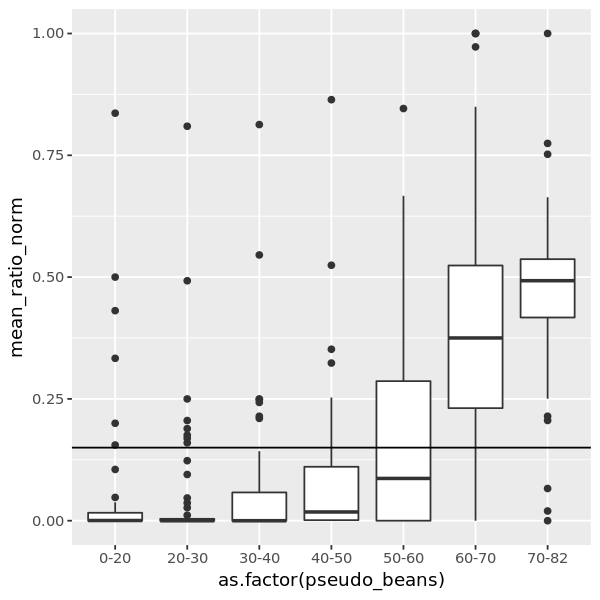

In [27]:
options(repr.plot.width=5, repr.plot.height=5)
allelic_pseudo_avg <- allelic %>% select(RNA_id, gene, Chr, pseudo_beans, sumReads, ratio_norm) %>%
            filter(gene %in% consistent_pseudo_bean$gene, 
                   sumReads > 10,
                  Chr == "chrX") %>% 
            group_by(pseudo_beans, gene) %>%
            summarize(mean_ratio_norm = mean(ratio_norm)) %>% ungroup() 

allelic_pseudo_avg %>%
            ggplot(aes(as.factor(pseudo_beans), mean_ratio_norm)) +
                    geom_boxplot() +
                    geom_hline(yintercept = 0.15)

In [28]:
library(tibble)
allelic_pseudo_avg_wide <- allelic_pseudo_avg %>% 
                                filter(gene != "Xist") %>%
                                spread(gene, mean_ratio_norm) %>% 
                                column_to_rownames("pseudo_beans") %>%
                                t()
                               

In [125]:
head(allelic_pseudo_avg_wide)

0-20       20-30       30-40     40-50       50-60     60-70    
1110012L19Rik 0.00000000 0.000000000 0.0000000 0.013563242 0.3333333 0.0000000
4933402E13Rik 0.00000000 0.005307775 0.0000000 0.027840758 0.3105111 0.0000000
Acot9         0.01671948 0.169158661 0.2486918 0.214084233 0.1080539 0.5311437
Arxes1        0.00000000 0.000000000 0.0000000 0.002137291 0.0000000 0.4238893
Arxes2        0.00000000 0.000000000 0.0000000 0.004930963 0.0000000 0.3522710
Atp6ap2       0.01719649 0.123195902 0.1093190 0.118108073 0.2801536 0.4340519
              70-82    
1110012L19Rik 0.4011495
4933402E13Rik 0.2057489
Acot9         0.4919154
Arxes1        0.4511614
Arxes2        0.4124262
Atp6ap2       0.5181365

In [29]:
dim(allelic_pseudo_avg_wide)

[1] 61  7

In [30]:
# Compute k-means with k = 6
set.seed(123)
km.res.pseudo <- kmeans(allelic_pseudo_avg_wide, 5,iter.max = 100, nstart = 100)

In [31]:
allelic_pseudo_avg_kmeans <- cbind(allelic_pseudo_avg_wide, k_means_cluster = km.res.pseudo$cluster) %>% 
                                as.data.frame() %>%
                                rownames_to_column("gene")

In [32]:
allelic_pseudo_avg_kmeans_long <- allelic_pseudo_avg_kmeans %>%
                                    gather(pseudo_beans, mean_ratio_norm,-gene, -k_means_cluster) 

In [33]:

kinetics_k_pseudo_plots <- list()

for (i in seq(unique(allelic_pseudo_avg_kmeans_long$k_means_cluster))){
    
kinetics_k_pseudo_plots[[i]] <- allelic_pseudo_avg_kmeans_long %>% filter(k_means_cluster == i) %>%
                            ggplot(aes(pseudo_beans, mean_ratio_norm, group = gene, color = gene)) +
                                geom_line() +
                                geom_hline(yintercept = c(0.15, 0.85), linetype = 'dashed', size = .5) +
                                                                             coord_cartesian(ylim = c(0,1))+
                                ylab("Mean allelic ratio")+
                                xlab("Pseudotime bin") +
                                theme_bw()
                                
    }



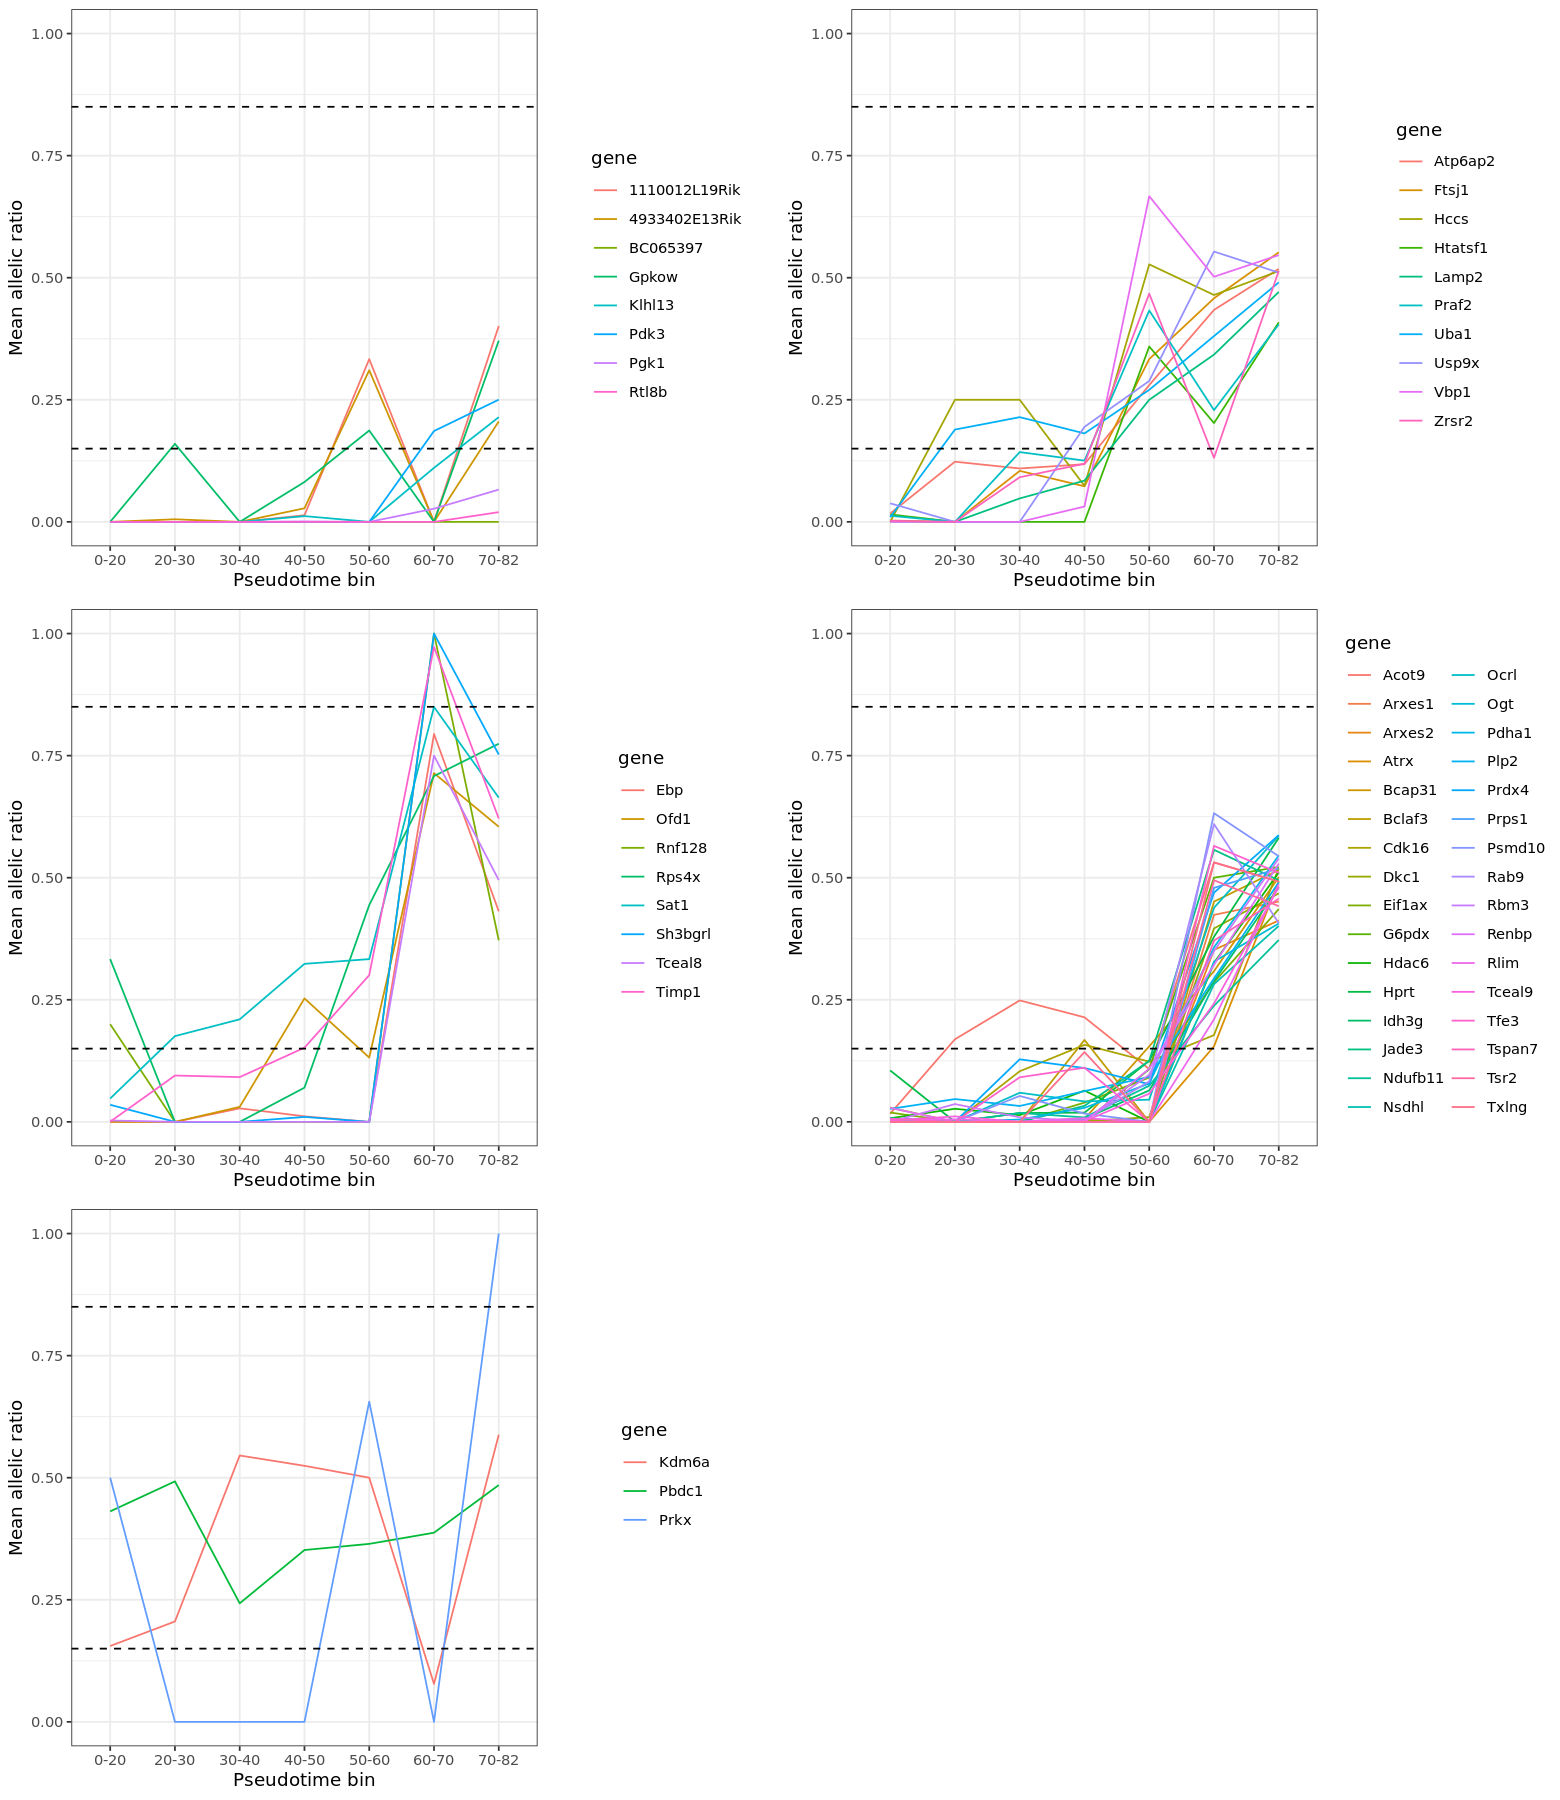

In [34]:
options(repr.plot.width=13, repr.plot.height=15)
CombinePlots(plots = kinetics_k_pseudo_plots, ncol=2)

## Plot XCR kinetics as a heatmap (columns pseudotime bins, rows genes)

In [35]:
allelic_pseudo_avg_kmeans_long$k_means_cluster <- factor(allelic_pseudo_avg_kmeans_long$k_means_cluster, levels = c(5,3,2,4,1))

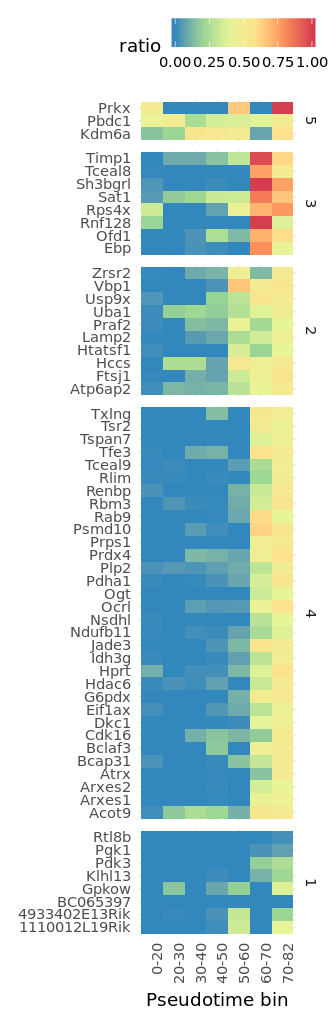

In [36]:
options(repr.plot.width=2.8, repr.plot.height=8.5)


allelic_pseudo_avg_kmeans_long %>% 
            ggplot(aes(x = as.factor(pseudo_beans), y = gene, fill = mean_ratio_norm)) +
                geom_tile() +
                facet_grid(k_means_cluster ~ ., scales = 'free', space = 'free_y') +
                #facet_wrap(. ~ k_means_cluster, scales="free_y", ncol = 1, strip.position = "right") +
                scale_fill_distiller(palette = "Spectral") +
                labs(x="Pseudotime bin", fill = "ratio") +
                
                theme_minimal()  +
                theme(legend.position = "top") +
                #theme(axis.text.y=element_blank()) +
                #theme(strip.background = element_blank(),
                #  strip.text.y = element_blank()) +
                theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
                theme(axis.title.y = element_blank())

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
"Removed 40 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 40 rows containing missing values (geom_point)."

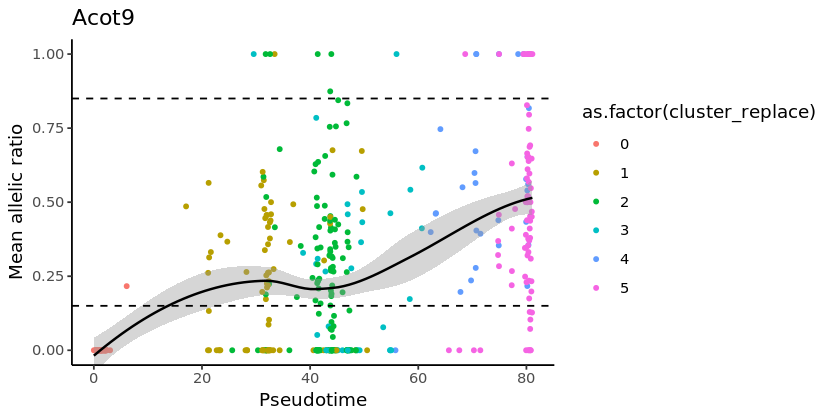

In [471]:
options(repr.plot.width=7, repr.plot.height=3.5)
allelic %>% 
        filter(gene == "Acot9") %>% 
        group_by(RNA_id, Pseudotime, cluster_replace) %>% 
        summarize(mean_mus = mean(mus_norm), mean_cast = mean(cast_norm) , mean_ratio = mean(ratio_norm)) %>%                         
            ggplot(aes(Pseudotime, mean_ratio)) +
                geom_point(size = 1, alpha = 1, aes(color = as.factor(cluster_replace))) +
                geom_smooth(color = "black", size = .7) +                                                     
                geom_hline(yintercept = c(0.15, 0.85), linetype = 'dashed', size = .5) +
                                                     coord_cartesian(ylim = c(0,1))+
               ylab("Mean allelic ratio")+
                ggtitle("Acot9") +
                theme_classic()   

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
"Removed 85 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 85 rows containing missing values (geom_point)."

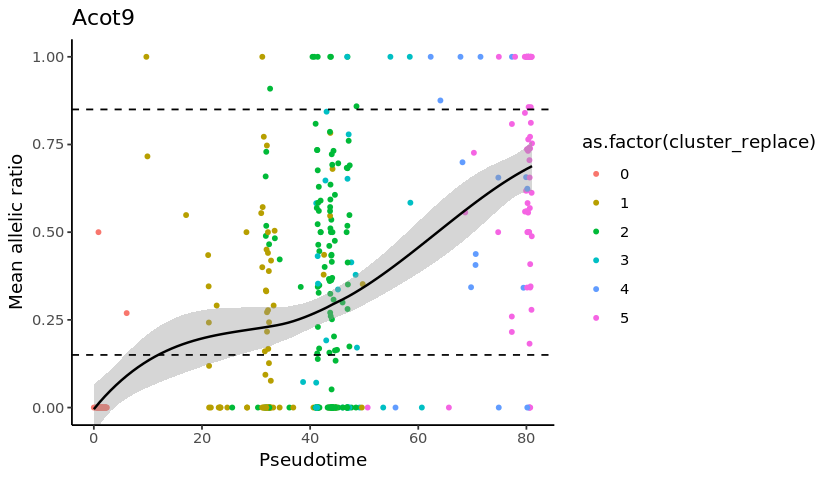

In [64]:
options(repr.plot.width=7, repr.plot.height=4)
allelic %>% filter(gene=="Sat1") %>% 
            ggplot(aes(Pseudotime, ratio_norm)) +
                geom_point(size = 1, alpha = 1, aes(color = as.factor(cluster_replace))) +
                geom_smooth(color = "black", size = .7) +                                                     
                geom_hline(yintercept = c(0.15, 0.85), linetype = 'dashed', size = .5) +
                                                     coord_cartesian(ylim = c(0,1))+
               ylab("Mean allelic ratio")+
                ggtitle("Acot9") +
                theme_classic()   

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
"Removed 89 rows containing non-finite values (stat_smooth)."

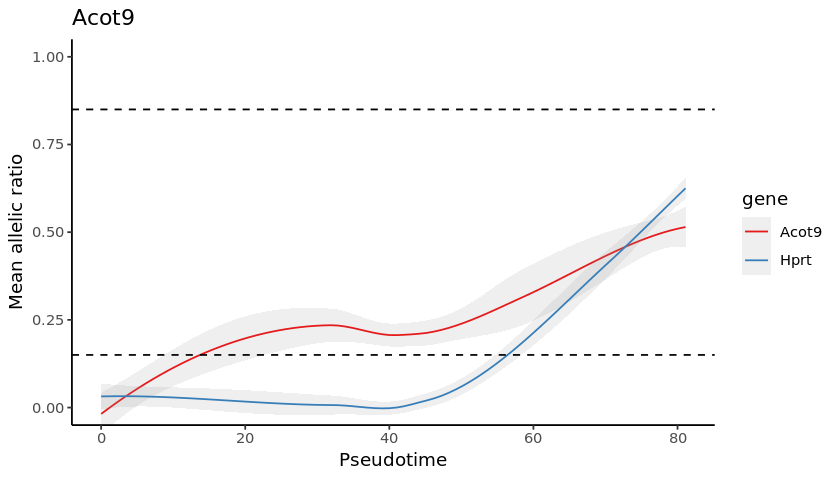

In [41]:
allelic %>% 
        filter(gene %in% c("Hprt","Acot9")) %>%
        group_by(gene, RNA_id, Pseudotime, cluster_replace) %>% 
        summarize(mean_mus = mean(mus_norm), mean_cast = mean(cast_norm) , mean_ratio = mean(ratio_norm)) %>%  
         ggplot(aes(Pseudotime, mean_ratio, color = gene)) +
                        #geom_point(size = 1, alpha = 1, aes(color = as.factor(cluster_replace))) +
                        geom_smooth( size = .5, alpha = .15) +                                                     
                        geom_hline(yintercept = c(0.15, 0.85), linetype = 'dashed', size = .5) +
                                                             coord_cartesian(ylim = c(0,1))+
                        ylab("Mean allelic ratio")+
                        ggtitle("Acot9") +
                        scale_color_brewer(palette="Set1")+
                        theme_classic()   

## Plot a heatmap of individual cells orodered by pseudotime

In [518]:
test <- allelic

ordered <- test %>% select(RNA_id, Pseudotime) %>% arrange(Pseudotime) %>% distinct(RNA_id) 

In [542]:
clusters <- as.data.frame(km.res.pseudo$cluster) %>% 
                    rownames_to_column("gene") %>% 
                    rename(pseudo_k_clust = "km.res.pseudo$cluster") %>% 
                    filter(pseudo_k_clust == 2)


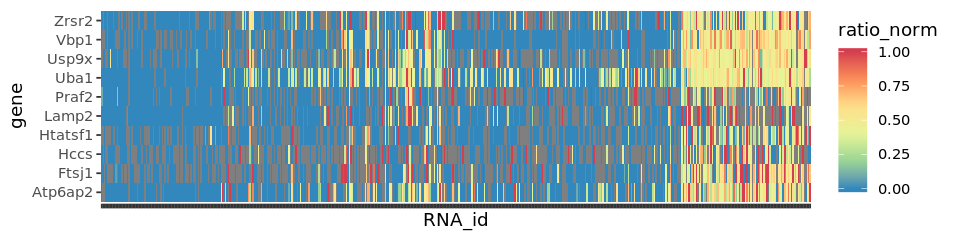

In [543]:
options(repr.plot.width=8, repr.plot.height=2)

test$RNA_id <- factor(test$RNA_id, levels = ordered$RNA_id)

allelic %>% 
        filter(gene %in% clusters$gene) %>%
        ggplot(aes(RNA_id, gene, fill = ratio_norm)) +
        geom_tile() +
scale_fill_distiller(palette = "Spectral") +
        theme(axis.text.x = element_blank()) 

In [550]:
clusters <- as.data.frame(km.res.pseudo$cluster) %>% rownames_to_column("gene") %>% rename(pseudo_k_clust = "km.res.pseudo$cluster") %>% filter(pseudo_k_clust == 4)


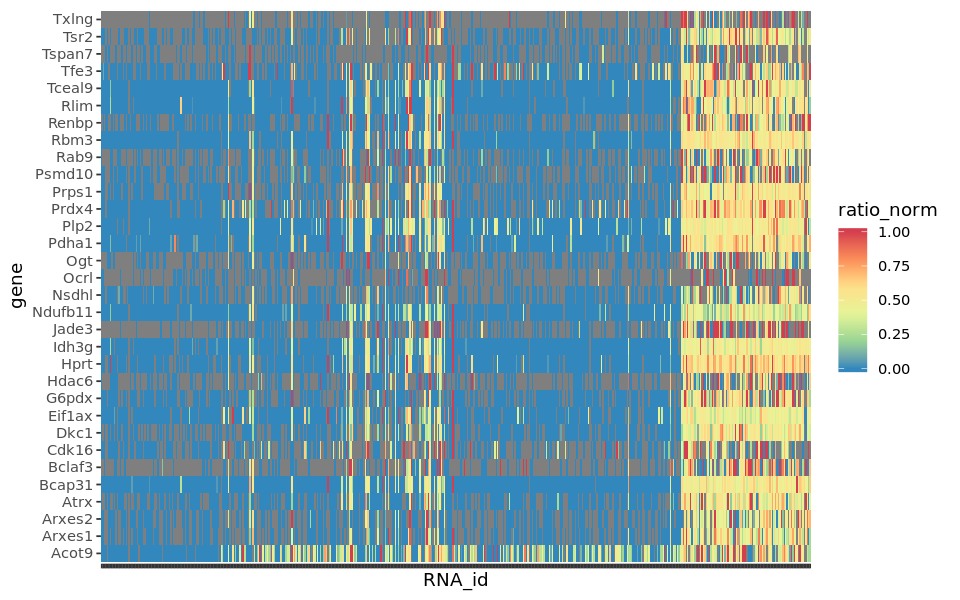

In [551]:
options(repr.plot.width=8, repr.plot.height=5)

test$RNA_id <- factor(test$RNA_id, levels = ordered$RNA_id)

allelic %>% 
        filter(gene %in% clusters$gene) %>%
        ggplot(aes(RNA_id, gene, fill = ratio_norm)) +
        geom_tile() +
scale_fill_distiller(palette = "Spectral") +
        theme(axis.text.x = element_blank()) 

## Cluster genes based on the ratio modelled along the pseudotime and make a heatmap

## To do

0) Plot all genes with loess fitting and se individually (checking if spanning works for all genes and to show underlying data in supplements)  
1) Generate a loess model for a gene  
2) for each pseudotime unit 1,2,3...80 (or more densely) measure the y intercept and store in df  
3) Repeat for all genes  
4) Combine dfs  
5) Cluster with k-means   
6) Heatmap  


In [22]:
allelic %>% head()

X1 gene          RNA_id           X       X129 Cast sumReads ratioPercent
1 1  0610009B22Rik Day_10_Xi_Mus_59 2323152 0    0    0            NA      
2 2  0610009B22Rik Day_10_Xi_Mus_15 1559376 0    0    0            NA      
3 3  0610009B22Rik Day_10_Xi_Mus_55 2259504 0    4    4        0.0001      
4 4  0610009B22Rik Day_12_Xi_Mus_85 5823792 1    7    8        0.1251      
5 5  0610009B22Rik Day_12_Xi_Mus_87 5855616 0    0    0            NA      
6 6  0610009B22Rik Day_9_Xi_Mus_26  7765056 4    0    4        1.0001      
  ratioLog   Pseudotime ... Xi  X2  cluster cluster_replace Chr   total_reads
1         NA 43.62880   ... Mus 226 0       2               chr11  88329     
2         NA 48.75234   ... Mus  58 4       3               chr11  10125     
3 -13.287712 44.71111   ... Mus 222 0       2               chr11 115942     
4  -2.806345 32.38629   ... Mus 397 1       1               chr11 142685     
5         NA 79.94168   ... Mus 391 5       4               chr11 202247     
6        Inf 46.96879   ... Mus  11 0       2               chr11 181032     
  mus_norm   cast_norm ratio_norm sum_norm 
1 0.00000000 0.0000000        NA  0.0000000
2 0.00000000 0.0000000        NA  0.0000000
3 0.00000000 0.2963941 0.0000000  0.2963941
4 0.06773757 0.3991728 0.1450762  0.4669104
5 0.00000000 0.0000000        NA  0.0000000
6 0.19963368 0.0000000 1.0000000  0.1996337

#### 0) Plot all genes with loess fitting and se individually (checking if spanning works for all genes and to show underlying data in supplements)

In [98]:
plots <- list()

genes <- consistent_cluster$gene

for(i in seq(genes)){

plots[[i]] <- allelic %>% 
        filter(gene == genes[i]) %>%                   
            ggplot(aes(Pseudotime, ratio_norm)) +
                geom_point(size = 1, alpha = 1, aes(color = as.factor(cluster_replace))) +
                geom_smooth(color = "black", size = .7) +                                                     
                geom_hline(yintercept = c(0.15, 0.85), linetype = 'dashed', size = .5) +
                                                     coord_cartesian(ylim = c(0,1))+
                ggtitle(paste0(genes[i])) +
                theme_classic()   +
                theme(legend.position = "none") 
}


plots <- CombinePlots(plots = plots, ncol=4)

In [100]:
pdf("AJ_0065.9_Cluster_consist_genes_loess_all.pdf", width=13, height=50)
plot(plots)
dev.off()

png 
  2

#### Set up modelling example

Warning message:
"Removed 85 rows containing non-finite values (stat_smooth)."

X1      gene RNA_id           X       X129 Cast sumReads ratioPercent
1 5982556 Sat1 Day_12_Xi_Mus_69 5549511  0    30   30      0.0001000   
2 5982558 Sat1 Day_10_Xi_Mus_12 1523775  0   105  105      0.0001000   
3 5982560 Sat1 Day_10_Xi_Mus_43 2064783  0    16   16      0.0001000   
4 5982562 Sat1 Day_0_Xi_Mus_75  1110063  0    11   11      0.0001000   
5 5982564 Sat1 Day_12_Xi_Mus_56 5326743 11     0   11      1.0001000   
6 5982566 Sat1 Day_8_Xi_Mus_18  6170079  6     8   14      0.4286714   
  ratioLog    Pseudotime ... cluster_replace Chr  total_reads mus_norm 
1 -13.2877124 33.1709944 ... 1               chrX  71416      0.0000000
2 -13.2877124 31.3767981 ... 1               chrX 153050      0.0000000
3 -13.2877124 30.3503100 ... 2               chrX  74480      0.0000000
4 -13.2877124  0.8525002 ... 0               chrX 111172      0.0000000
5         Inf 67.8072883 ... 4               chrX  74653      0.9056277
6  -0.4148452 31.9402983 ... 1               chrX  57698      0.7128995
  cast_norm ratio_norm sum_norm  .fitted    .se.fit    .resid     
1 1.6488008 0.0000000  1.6488008 0.23269768 0.02741166 -0.23269768
2 2.0618506 0.0000000  2.0618506 0.22823037 0.02993108 -0.22823037
3 1.1468397 0.0000000  1.1468397 0.22581295 0.03078945 -0.22581295
4 0.6878621 0.0000000  0.6878621 0.01129669 0.03349246 -0.01129669
5 0.0000000 1.0000000  0.9056277 0.55189461 0.04258973  0.44810539
6 0.8698404 0.4504211  1.5827399 0.22958492 0.02936208  0.22083623

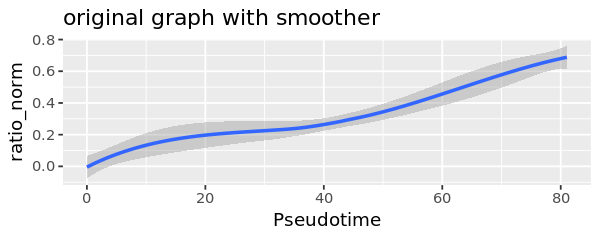

gene pseudotime fitted_data 
1 Sat1 0          -0.004631993
2 Sat1 1           0.013971104
3 Sat1 2           0.031183233
4 Sat1 3           0.047244262
5 Sat1 4           0.062293539
6 Sat1 5           0.076369694

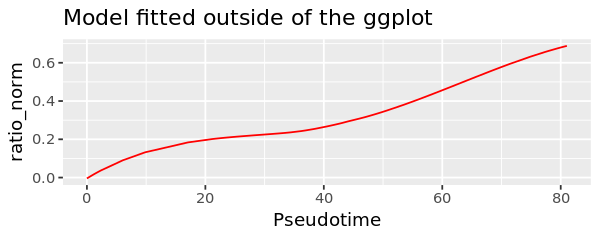

In [21]:
options(repr.plot.width=5, repr.plot.height=2)

#library(tidyverse)
library(broom)

# Subset dataset
test <- allelic %>% filter(gene == "Sat1")

# original graph with smoother
ggplot(data=test, aes(Pseudotime,ratio_norm)) + 
  geom_smooth(method = "loess")+
    ggtitle("original graph with smoother")

# Create model that will do the same thing as under the hood in ggplot2
model <- loess(ratio_norm ~ Pseudotime, data = test, span = 0.75)

# Add predicted values from model to original dataset using broom library
test2 <- augment(model, test)
test2 %>% head()

# Plot the fit of the model generated outside ggplot

ggplot(data=test2, aes(Pseudotime,ratio_norm)) + 
  geom_line(aes(Pseudotime, .fitted), color = "red") +
  #stat_smooth(method = "loess", span = 0.75) +
    ggtitle("Model fitted outside of the ggplot")

# Predict for a complete range of new data points
# This way for all genes I will the same, complete, set of values that I can do k-means on and the heatmap

new_data <- predict(model, newdata = 0:80, se = TRUE)
new_data <- data.frame(gene = rep("Sat1"), pseudotime = 0:80, fitted_data = new_data$fit)
head(new_data)

#### Expand the fitting to all genes at once

In [22]:
# Wrap fitting and adding model to the input df in a single function

fit_n_add <- function(data, y, x, gene, range, span = 0.75){
    
    # Create model that will do the same thing as under the hood in ggplot2
        model <- loess(y ~ x, data = data, span = span)

    # Add predicted values from model to original dataset using broom library
        # This is not going to be used, but might be useful other time
        # df <- augment(model, data)
    
    # Create a new data frame which links gene and fitted norm_ratio value for the pseudotime range of 0:80
    
    predicted <- predict(model, newdata = range, se = TRUE)
    
    df <- data.frame(gene = gene, pseudotime = range, fitted_data = predicted$fit)
    
    return(df)
}

In [25]:
# Calculate fitted lines for all cluster consistent X-linked genes

library(purrr)

allelic_fit_chrX_clust_cons <- allelic %>% filter(gene %in% consistent_cluster$gene) %>%
                                group_split(gene) %>%
                                map(~fit_n_add(data = .,
                                               y = .$ratio_norm,
                                               x = .$Pseudotime,
                                               gene = .$gene[1],
                                               range = 2:80)) %>%
                                bind_rows() 

Warning message in bind_rows_(x, .id):
"Unequal factor levels: coercing to character"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding cha

In [26]:
# K-means clustering based on fitted trends

allelic_fit_chrX_clust_cons_mtx <- allelic_fit_chrX_clust_cons %>% 
                filter(gene != "Xist") %>% 
                spread(pseudotime, fitted_data) %>% 
                column_to_rownames("gene")

# Compute k-means with k = 6
set.seed(123)
km.res.fit <- kmeans(allelic_fit_chrX_clust_cons_mtx, 5,iter.max = 100, nstart = 100)

allelic_fit_kmeans <- cbind(allelic_fit_chrX_clust_cons_mtx, k_means_cluster = km.res.fit$cluster) %>% 
                                as.data.frame() %>%
                                rownames_to_column("gene")

allelic_fit_kmeans_long <- allelic_fit_kmeans %>%
                                    gather(pseudotime, fitted_data,-gene, -k_means_cluster) 

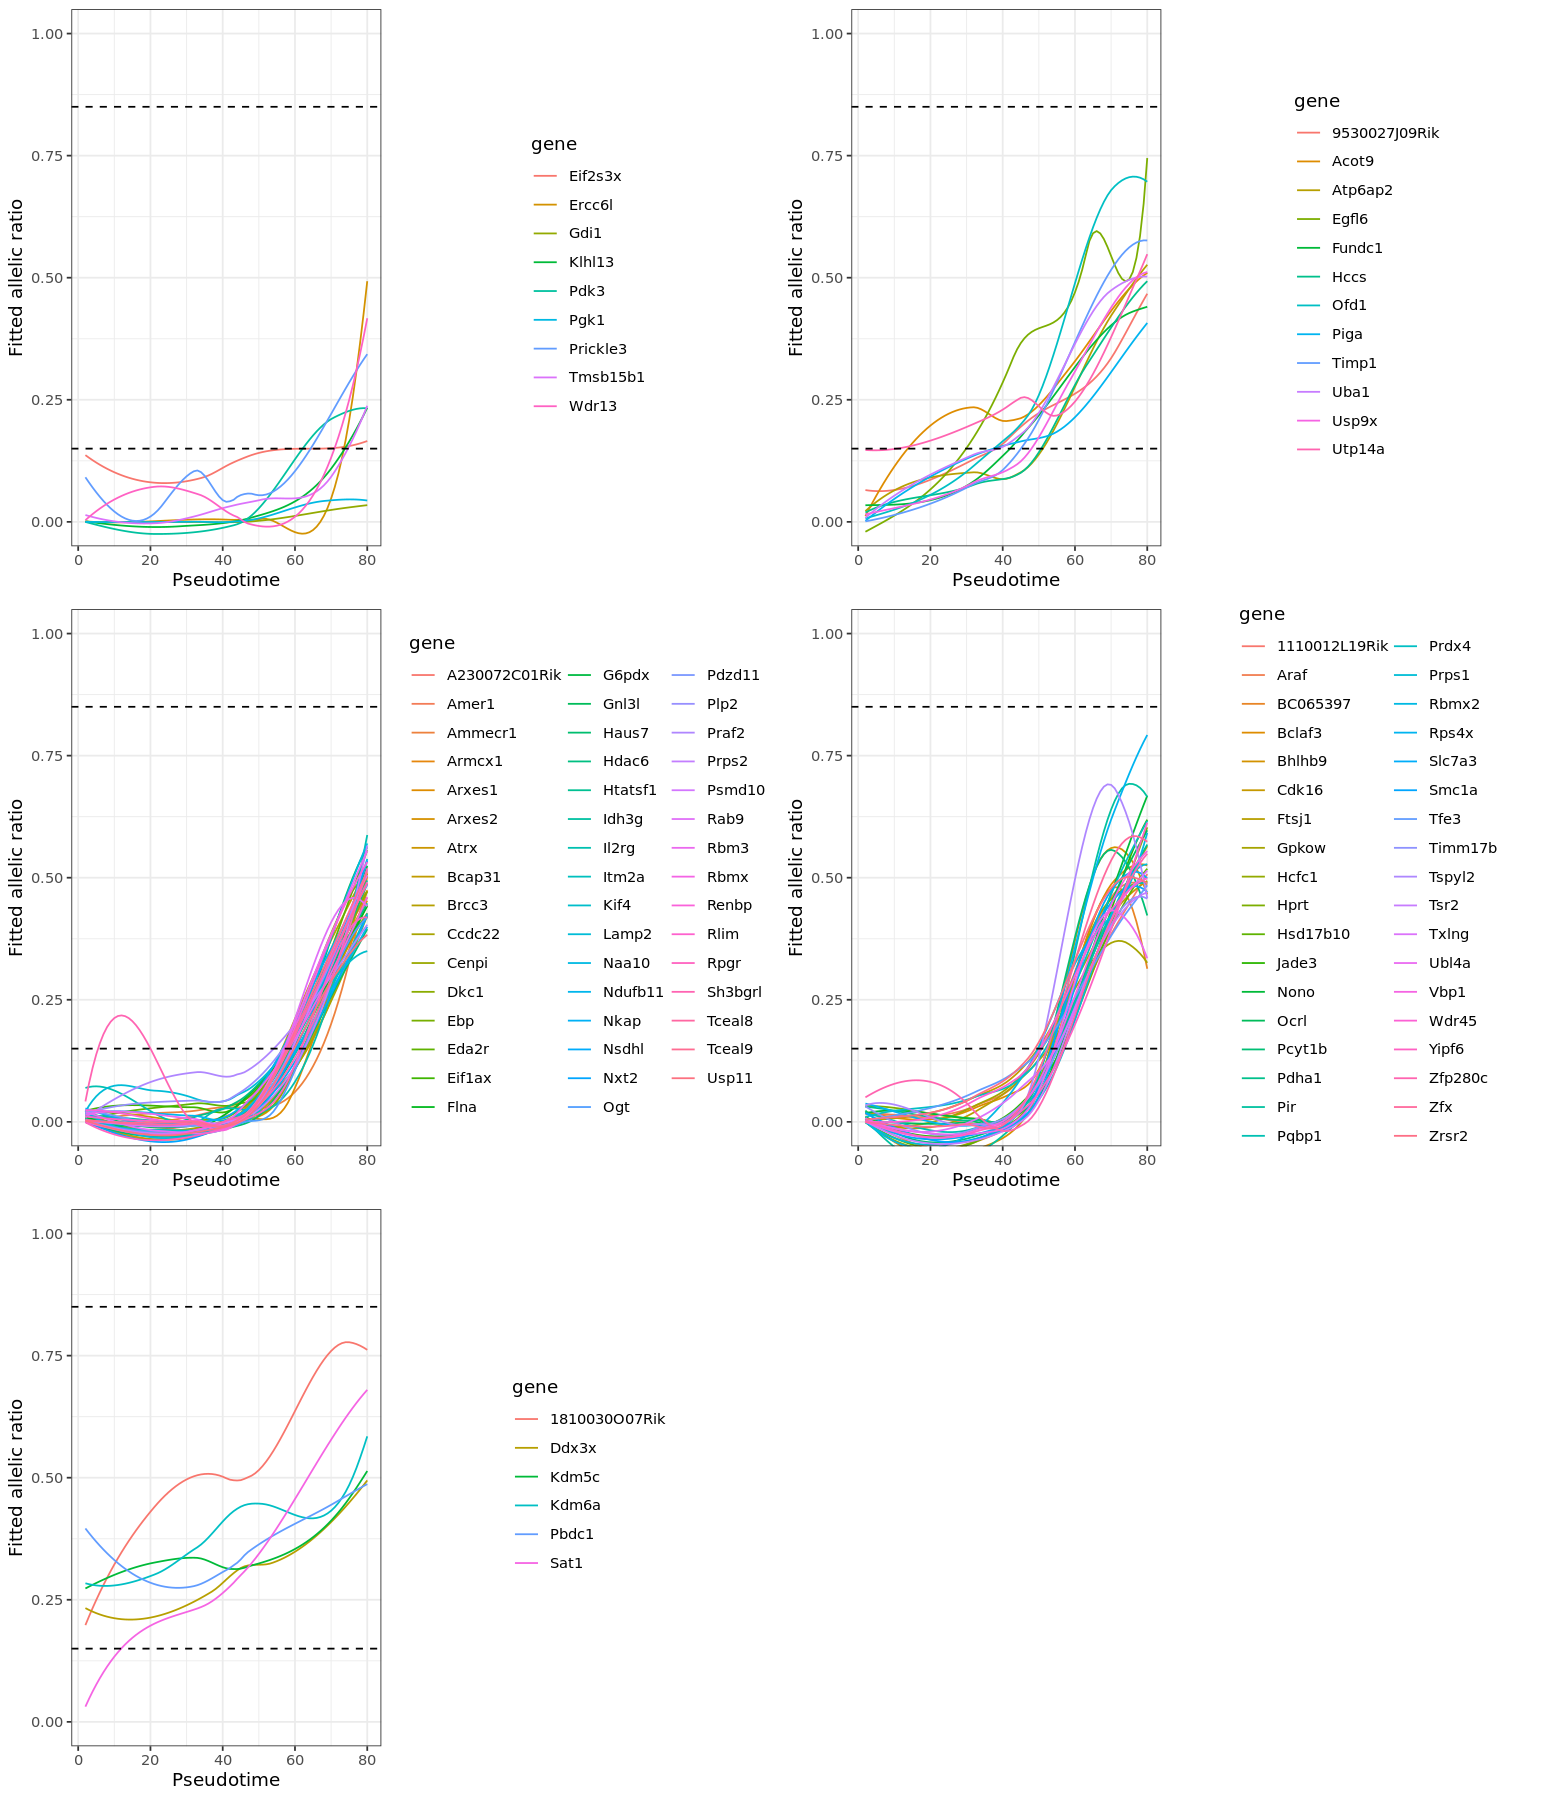

In [27]:
# Visualize clustered fitted models

kinetics_k_fit_plots <- list()

for (i in seq(unique(allelic_fit_kmeans_long$k_means_cluster))){
    
kinetics_k_fit_plots[[i]] <- allelic_fit_kmeans_long %>% filter(k_means_cluster == i) %>%
                            ggplot(aes(as.integer(pseudotime), fitted_data, group = gene, color = gene)) +
                                geom_line() +
                                geom_hline(yintercept = c(0.15, 0.85), linetype = 'dashed', size = .5) +
                                                                             coord_cartesian(ylim = c(0,1))+
                                ylab("Fitted allelic ratio")+
                                xlab("Pseudotime") +
                                theme_bw()
                                
    }

options(repr.plot.width=13, repr.plot.height=15)
CombinePlots(plots = kinetics_k_fit_plots, ncol=2)

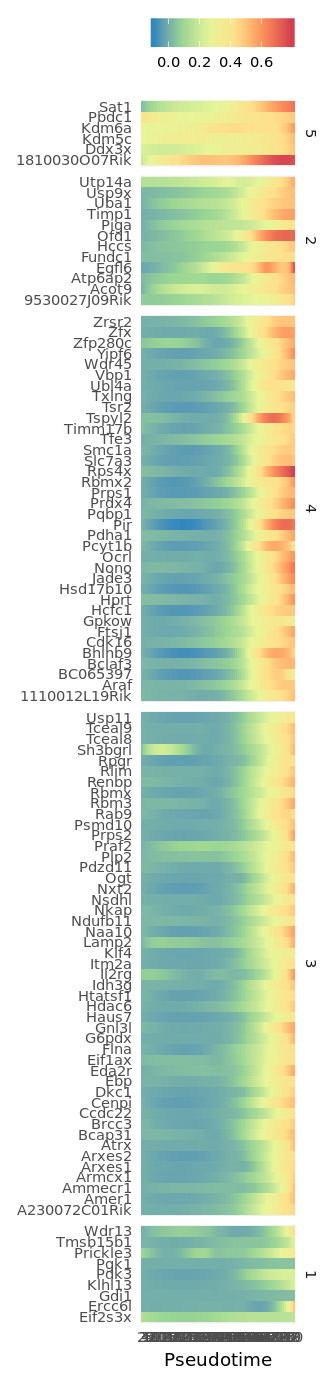

In [28]:
options(repr.plot.width=2.8, repr.plot.height=11.5)

allelic_fit_kmeans_long$pseudotime_fct <- factor(allelic_fit_kmeans_long$pseudotime, levels = sort(unique(as.integer(allelic_fit_kmeans_long$pseudotime))))
allelic_fit_kmeans_long$k_means_cluster <- factor(allelic_fit_kmeans_long$k_means_cluster, levels = c(5, 2, 4, 3, 1))

allelic_fit_heatmap <- allelic_fit_kmeans_long %>% 
            ggplot(aes(x = pseudotime_fct, y = gene, fill = fitted_data)) +
                geom_tile() +
                facet_grid(k_means_cluster ~ ., scales = 'free', space = 'free_y') +
                #facet_wrap(. ~ k_means_cluster, scales="free_y", ncol = 1, strip.position = "right") +
                scale_fill_distiller(palette = "Spectral") +
                labs(x="Pseudotime", fill = "") +
                
                theme_minimal()  +
                theme(legend.position = "top") +
                #theme(axis.text.y=element_blank()) +
                #theme(strip.background = element_blank(),
                #  strip.text.y = element_blank()) +
                #theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
                theme(axis.title.y = element_blank()) 
               
allelic_fit_heatmap

In [35]:
pdf("allele_specific/XCR/allelic_fit_heatmap_MusCast_ratio.pdf", width=2.8, height=11.5)
plot(allelic_fit_heatmap)
dev.off()

png 
  2

#### Check if early genes are more expressed in MEFs (cluster 0) than other groups

In [63]:
sc_denovo_kinetics <- allelic_fit_kmeans_long %>% 
                            select(gene, k_means_cluster) %>%
                            distinct(gene, .keep_all = T) %>%
                            mutate(kinetics_category = case_when(k_means_cluster == 5 ~ "escapee",
                                                                k_means_cluster == 2 ~ "early",
                                                                k_means_cluster == 4 ~ "intermediate",
                                                                k_means_cluster == 3 ~ "late",
                                                                TRUE ~ "very_late"))

write.csv(sc_denovo_kinetics, "sc_denovo_kinetics.csv")

In [59]:
sc_denovo_kinetics$kinetics_category <- factor(sc_denovo_kinetics$kinetics_category, levels = c("early","intermediate",
                                                                                               "late","very_late",
                                                                                               "escapee"))

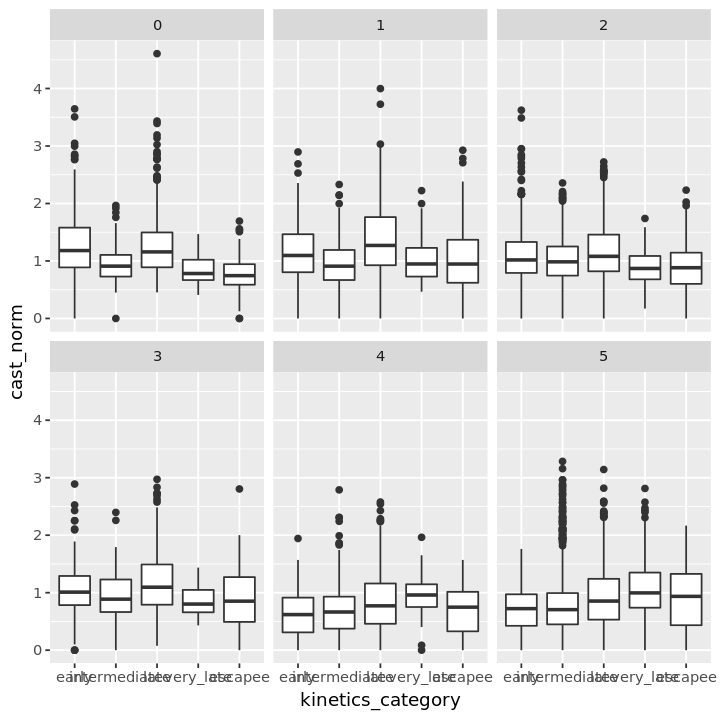

In [62]:
options(repr.plot.width = 6, repr.plot.height = 6)
allelic %>% 
    filter(Chr == "chrX", 
          # cluster_replace == ,
           sumReads > 10,
           gene %in% sc_denovo_kinetics$gene) %>%
           left_join(sc_denovo_kinetics, by = "gene" ) %>%
    ggplot(aes(kinetics_category, cast_norm))+
        geom_boxplot()+
        facet_wrap(. ~ cluster_replace)

#### Check if early genes initiate reactivation before Xist

In [65]:
# need to pull-out Xist expression from non-allelic analysis
data_non_allelic <- read_csv("/staging/leuven/stg_00041/Adrian/AJ_0065.4-Monocle3/seurat_pseudotime.csv")

Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  .default = col_double(),
  X1 = col_character(),
  orig.ident = col_character(),
  Timepoint = col_character(),
  Xi = col_character(),
  GC_index1_index2 = col_character(),
  Name = col_character(),
  Name.1 = col_character(),
  Name.2 = col_character()
)
See spec(...) for full column specifications.


In [96]:
Xist_non_allelic <- data_non_allelic %>% select(Name, Pseudotime, Xist) 

In [97]:
Xist_non_allelic <- Xist_non_allelic %>% rename(RNA_id = Name, mus_norm = Xist) %>% mutate(gene = "Xist")

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


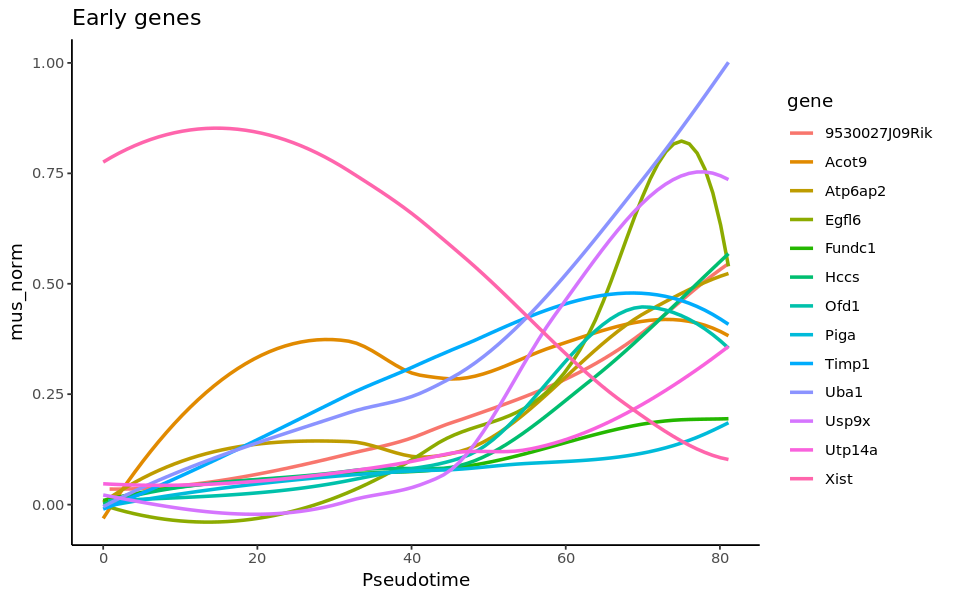

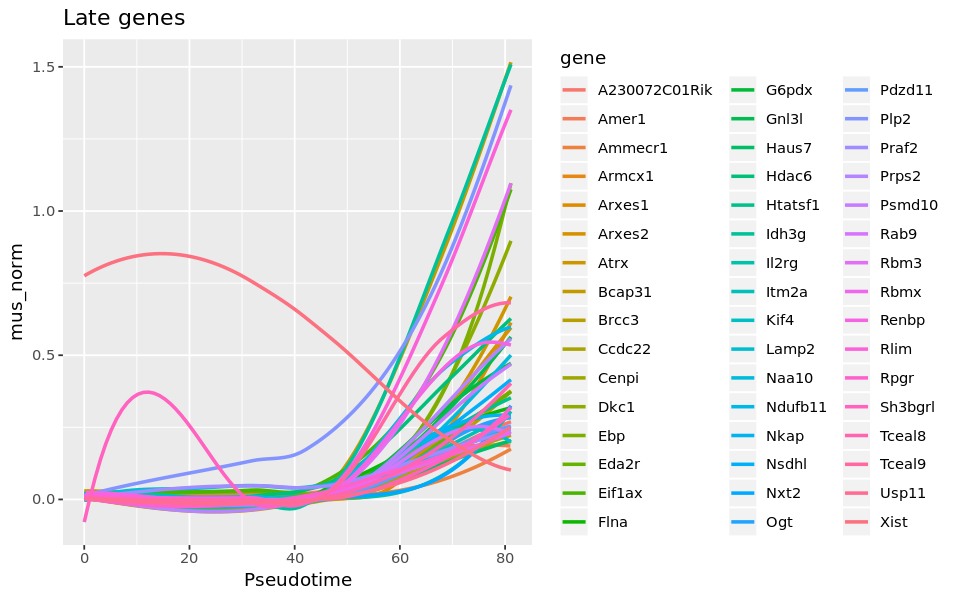

In [115]:
options(repr.plot.width = 8, repr.plot.height = 5)
Xist_early <- allelic %>% 
    filter(Chr == "chrX", 
          # cluster_replace == ,
           sumReads > 1,
           gene %in% sc_denovo_kinetics$gene) %>%
           left_join(sc_denovo_kinetics, by = "gene" ) %>% bind_rows(Xist_non_allelic) %>% 
        filter(kinetics_category == "early" | gene == "Xist") %>% 
    ggplot(aes(Pseudotime, mus_norm, color = gene)) +
        geom_smooth(se = FALSE)+
        ggtitle("Early genes") +
        theme_classic()
Xist_early

allelic %>% 
    filter(Chr == "chrX", 
          # cluster_replace == ,
           sumReads > 1,
           gene %in% sc_denovo_kinetics$gene) %>%
           left_join(sc_denovo_kinetics, by = "gene" ) %>% bind_rows(Xist_non_allelic) %>% 
        filter(kinetics_category == "late" | gene == "Xist") %>% 
    ggplot(aes(Pseudotime, mus_norm, color = gene)) +
        geom_smooth(se = FALSE)+
        ggtitle("Late genes")

In [110]:
getwd()

[1] "/ddn1/vol1/staging/leuven/stg_00041/Adrian/AJ_0065.9-sc_allele_specific"

In [116]:
pdf("allele_specific/XCR/Xist_early_timing.pdf", width = 8, height = 5)
plot(Xist_early)
dev.off()

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


png 
  2

In [88]:
Xist_non_allelic %>% head()

RNA_id           expression gene
1 Day_9_Xi_Mus_33  0.8851892  Xist
2 Day_10_Xi_Mus_25 0.0000000  Xist
3 Day_10_Xi_Mus_32 0.0000000  Xist
4 Day_9_Xi_Mus_27  0.7801563  Xist
5 Day_9_Xi_Mus_36  0.0000000  Xist
6 Day_10_Xi_Mus_30 0.0000000  Xist

In [143]:
allelic_fit_chrX_clust_cons %>% head()

X1   gene          RNA_id          X       X129 Cast sumReads ratioPercent
1 9369 1110012L19Rik Day_0_Xi_Mus_71 1034299 0    11   11       0.0001000   
2 9371 1110012L19Rik iPSCs_Xi_Mus_14 9085771 4     7   11       0.3637364   
3 9372 1110012L19Rik iPSCs_Xi_Mus_48 9674515 0     9    9       0.0001000   
4 9376 1110012L19Rik Day_8_Xi_Mus_42 6555763 0    12   12       0.0001000   
5 9378 1110012L19Rik Day_9_Xi_Mus_94 8958475 0    10   10       0.0001000   
6 9381 1110012L19Rik Day_0_Xi_Mus_89 1320715 0    14   14       0.0001000   
  ratioLog    Pseudotime ... total_reads mus_norm  cast_norm ratio_norm
1 -13.2877124  1.575439  ... 137030      0.0000000 0.5893099 0.0000000 
2  -0.8071025 80.687901  ... 152189      0.2333561 0.3784052 0.3814496 
3 -13.2877124 80.078770  ...  80637      0.0000000 0.7495809 0.0000000 
4 -13.2877124 31.702926  ...  51891      0.0000000 1.1977152 0.0000000 
5 -13.2877124 44.584084  ...  74271      0.0000000 0.8528910 0.0000000 
6 -13.2877124  1.267202  ... 193050      0.0000000 0.5453434 0.0000000 
  sum_norm  pseudo_beans .fitted      .se.fit    .resid       pseudo_k_clust
1 0.5893099 0-20          0.018497679 0.04233941 -0.018497679 1             
2 0.6117613 70-82         0.515899664 0.03257168 -0.134450077 1             
3 0.7495809 70-82         0.508568407 0.03022858 -0.508568407 1             
4 1.1977152 30-40        -0.003716625 0.03292326  0.003716625 1             
5 0.8528910 40-50         0.027463741 0.02191172 -0.027463741 1             
6 0.5453434 0-20          0.018576549 0.04309040 -0.018576549 1

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
"Removed 85 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 85 rows containing missing values (geom_point)."

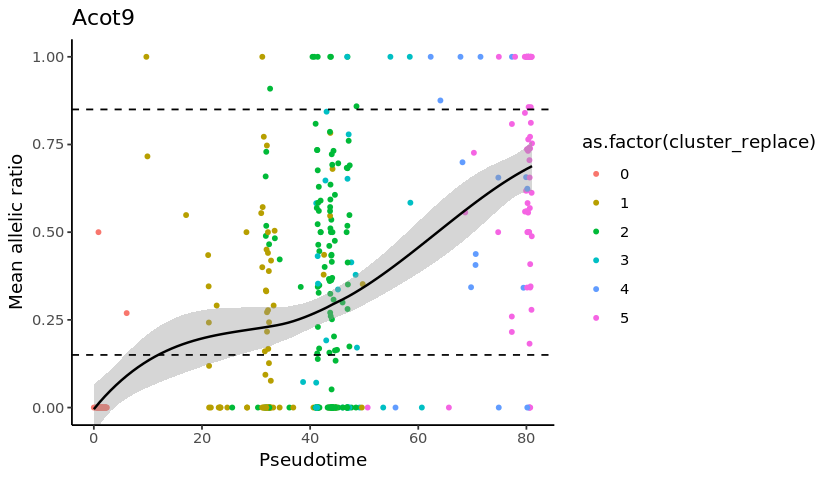

In [67]:
allelic %>% filter(gene=="Sat1") %>% 
            ggplot(aes(Pseudotime, ratio_norm)) +
                geom_point(size = 1, alpha = 1, aes(color = as.factor(cluster_replace))) +
                geom_smooth(color = "black", size = .7) +                                                     
                geom_hline(yintercept = c(0.15, 0.85), linetype = 'dashed', size = .5) +
                                                     coord_cartesian(ylim = c(0,1))+
               ylab("Mean allelic ratio")+
                ggtitle("Acot9") +
                theme_classic()   

# Define the kinetics of XCR using directly expression of Mus allele (Not Mus/Cast ratio)

In [36]:
allelic %>% head()

X1 gene          RNA_id           X       X129 Cast sumReads ratioPercent
1 1  0610009B22Rik Day_10_Xi_Mus_59 2323152 0    0    0            NA      
2 2  0610009B22Rik Day_10_Xi_Mus_15 1559376 0    0    0            NA      
3 3  0610009B22Rik Day_10_Xi_Mus_55 2259504 0    4    4        0.0001      
4 4  0610009B22Rik Day_12_Xi_Mus_85 5823792 1    7    8        0.1251      
5 5  0610009B22Rik Day_12_Xi_Mus_87 5855616 0    0    0            NA      
6 6  0610009B22Rik Day_9_Xi_Mus_26  7765056 4    0    4        1.0001      
  ratioLog   Pseudotime ... Xi  X2  cluster cluster_replace Chr   total_reads
1         NA 43.62880   ... Mus 226 0       2               chr11  88329     
2         NA 48.75234   ... Mus  58 4       3               chr11  10125     
3 -13.287712 44.71111   ... Mus 222 0       2               chr11 115942     
4  -2.806345 32.38629   ... Mus 397 1       1               chr11 142685     
5         NA 79.94168   ... Mus 391 5       4               chr11 202247     
6        Inf 46.96879   ... Mus  11 0       2               chr11 181032     
  mus_norm   cast_norm ratio_norm sum_norm 
1 0.00000000 0.0000000        NA  0.0000000
2 0.00000000 0.0000000        NA  0.0000000
3 0.00000000 0.2963941 0.0000000  0.2963941
4 0.06773757 0.3991728 0.1450762  0.4669104
5 0.00000000 0.0000000        NA  0.0000000
6 0.19963368 0.0000000 1.0000000  0.1996337

In [37]:
# Calculate fitted lines for all cluster consistent X-linked genes

library(purrr)

allelic_fit_chrX_clust_cons_dir <- allelic %>% filter(gene %in% consistent_cluster$gene) %>%
                                group_split(gene) %>%
                                map(~fit_n_add(data = .,
                                               y = .$mus_norm,
                                               x = .$Pseudotime,
                                               gene = .$gene[1],
                                               range = 2:80)) %>%
                                bind_rows() 

Warning message in bind_rows_(x, .id):
"Unequal factor levels: coercing to character"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding cha

In [38]:
allelic_fit_chrX_clust_cons_dir %>% head()

gene          pseudotime fitted_data 
1 1110012L19Rik 2          0.0018753754
2 1110012L19Rik 3          0.0016252580
3 1110012L19Rik 4          0.0013876577
4 1110012L19Rik 5          0.0011630980
5 1110012L19Rik 6          0.0009521026
6 1110012L19Rik 7          0.0007551950

In [39]:
# K-means clustering based on fitted trends
library(tibble)
allelic_fit_chrX_clust_cons_mtx <- allelic_fit_chrX_clust_cons_dir %>% filter(gene != "Xist") %>% spread(pseudotime, fitted_data) %>% column_to_rownames("gene")

# Compute k-means with k = 6
set.seed(123)
km.res.fit <- kmeans(allelic_fit_chrX_clust_cons_mtx, 5,iter.max = 100, nstart = 100)

allelic_fit_kmeans <- cbind(allelic_fit_chrX_clust_cons_mtx, k_means_cluster = km.res.fit$cluster) %>% 
                                as.data.frame() %>%
                                rownames_to_column("gene")

allelic_fit_kmeans_long <- allelic_fit_kmeans %>%
                                    gather(pseudotime, fitted_data,-gene, -k_means_cluster) 

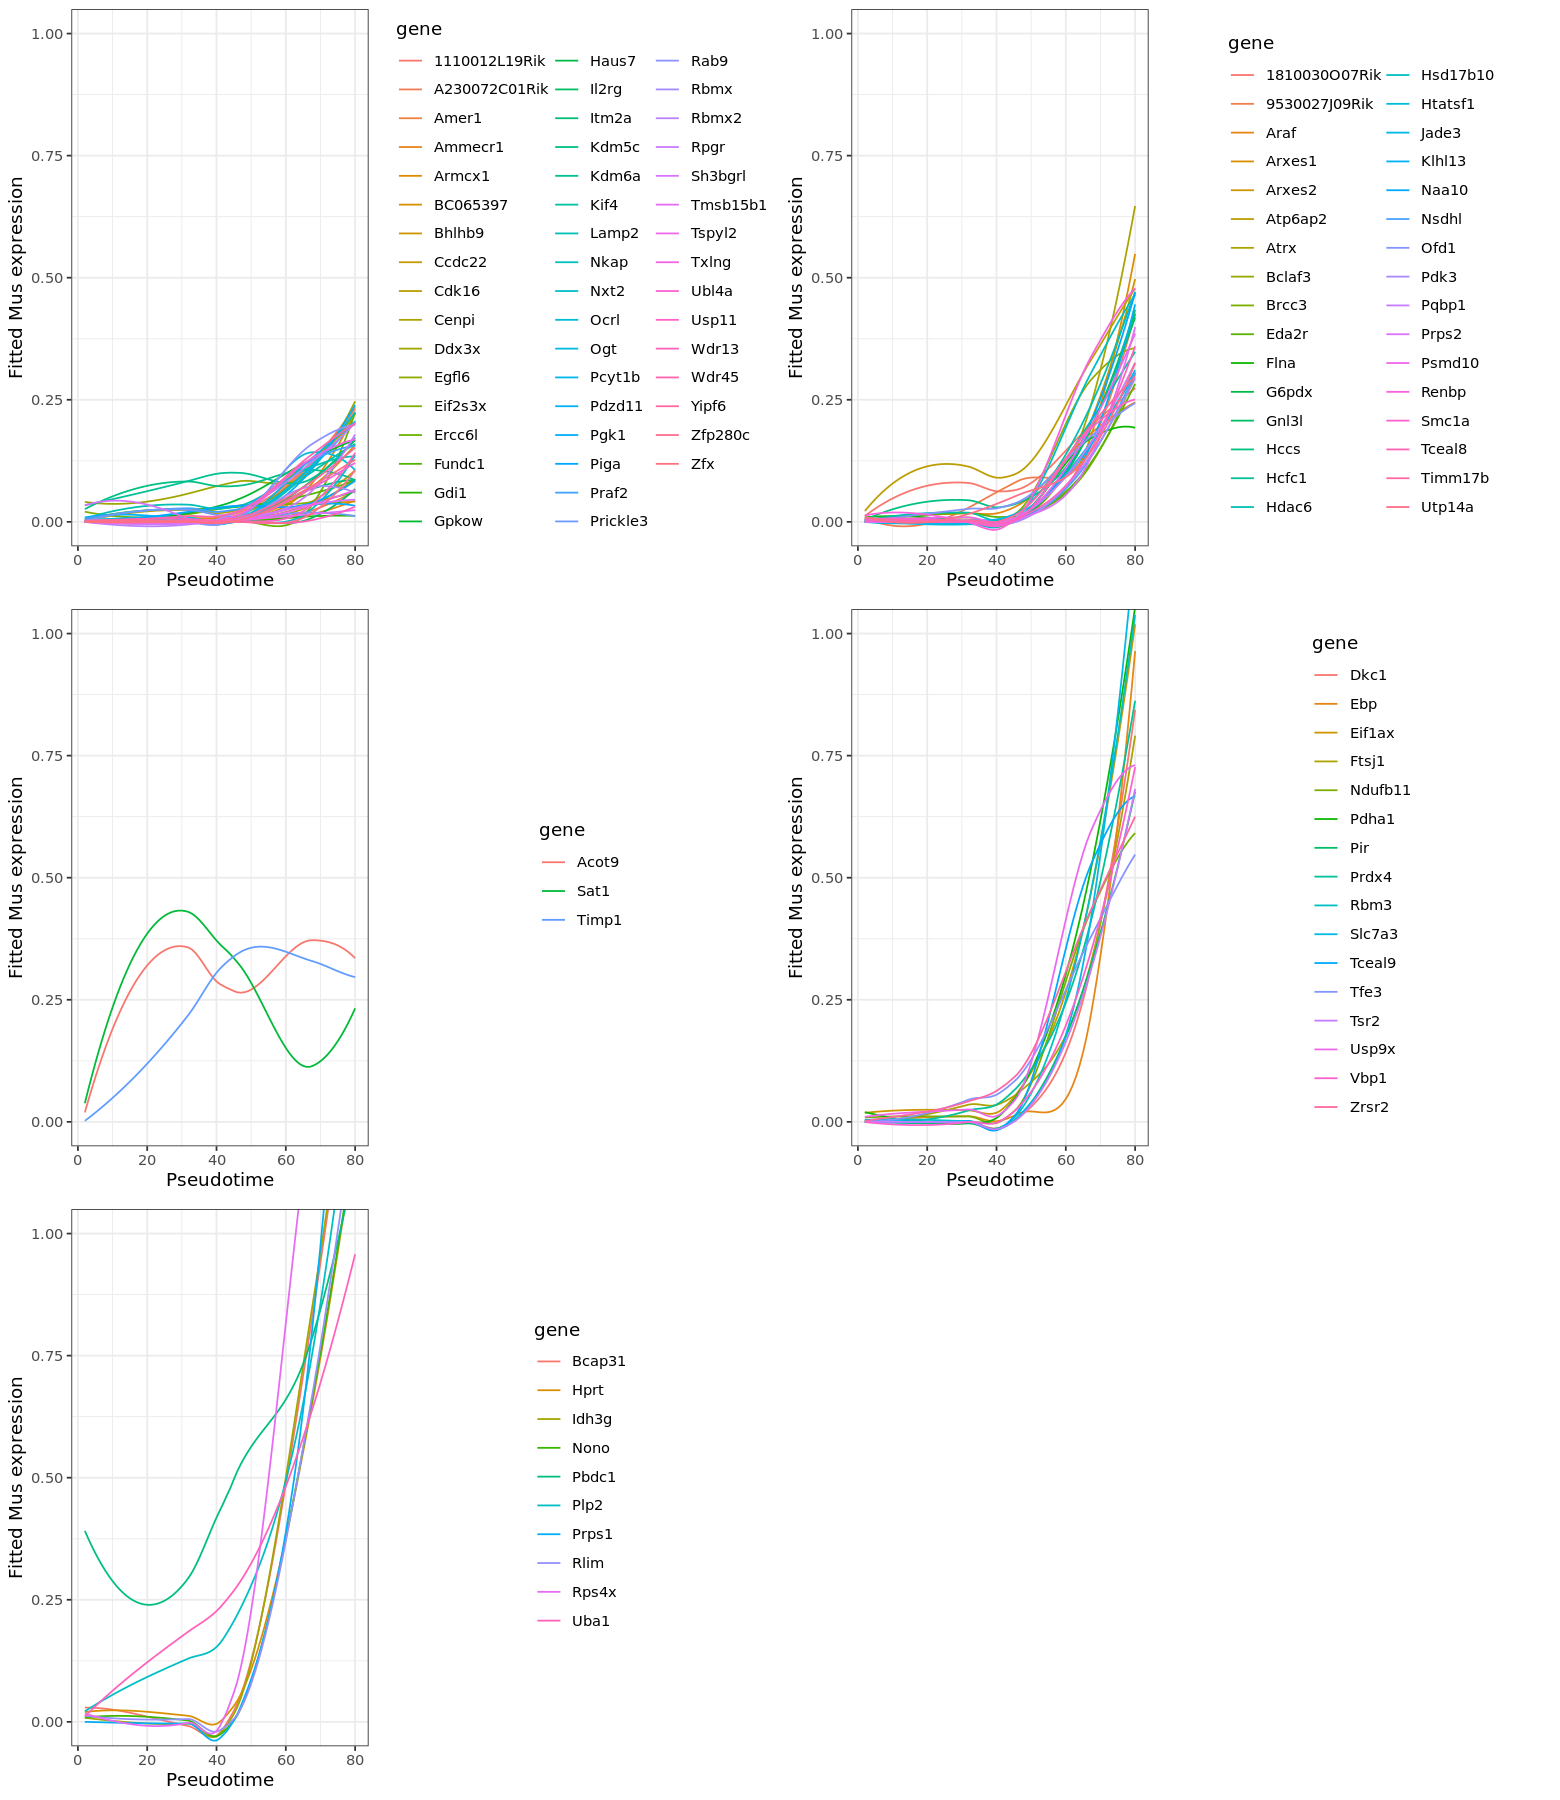

In [40]:
# Visualize clustered fitted models

kinetics_k_fit_plots <- list()

for (i in seq(unique(allelic_fit_kmeans_long$k_means_cluster))){
    
kinetics_k_fit_plots[[i]] <- allelic_fit_kmeans_long %>% filter(k_means_cluster == i) %>%
                            ggplot(aes(as.integer(pseudotime), fitted_data, group = gene, color = gene)) +
                                geom_line() +
                                #geom_hline(yintercept = c(0.15, 0.85), linetype = 'dashed', size = .5) +
                                                                             coord_cartesian(ylim = c(0,1))+
                                ylab("Fitted Mus expression")+
                                xlab("Pseudotime") +
                                theme_bw()
                                
    }

options(repr.plot.width=13, repr.plot.height=15)
CombinePlots(plots = kinetics_k_fit_plots, ncol=2)

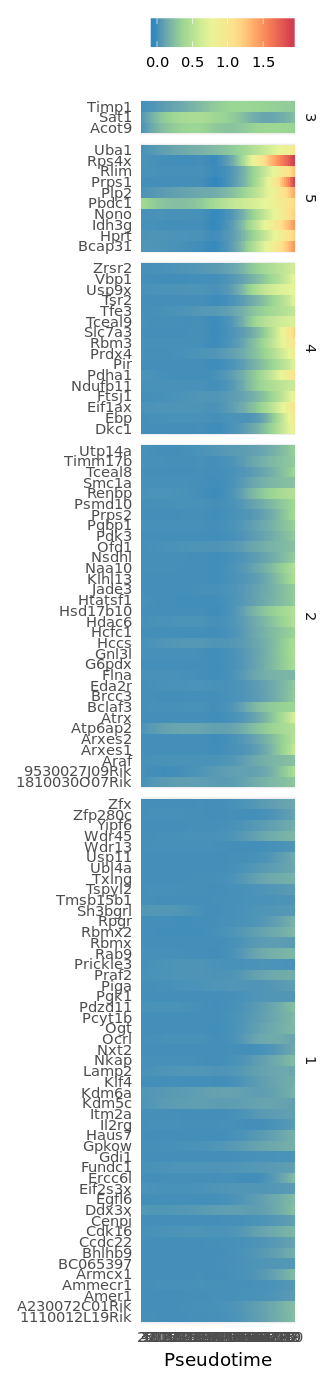

In [44]:
options(repr.plot.width=2.8, repr.plot.height=11.5)

allelic_fit_kmeans_long$pseudotime_fct <- factor(allelic_fit_kmeans_long$pseudotime, levels = sort(unique(as.integer(allelic_fit_kmeans_long$pseudotime))))
allelic_fit_kmeans_long$k_means_cluster <- factor(allelic_fit_kmeans_long$k_means_cluster, levels = c(3,5,4,2,1))

allelic_fit_kmeans_long_expression <- allelic_fit_kmeans_long %>% 
            ggplot(aes(x = pseudotime_fct, y = gene, fill = fitted_data)) +
                geom_tile() +
                facet_grid(k_means_cluster ~ ., scales = 'free', space = 'free_y') +
                #facet_wrap(. ~ k_means_cluster, scales="free_y", ncol = 1, strip.position = "right") +
                scale_fill_distiller(palette = "Spectral") +
                labs(x="Pseudotime", fill = "") +
                
                theme_minimal()  +
                theme(legend.position = "top") +
                #theme(axis.text.y=element_blank()) +
                #theme(strip.background = element_blank(),
                #  strip.text.y = element_blank()) +
                #theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
                theme(axis.title.y = element_blank())
allelic_fit_kmeans_long_expression

In [45]:
pdf("allele_specific/XCR/allelic_fit_heatmap_Mus_expr.pdf", width=2.8, height=11.5)
plot(allelic_fit_kmeans_long_expression)
dev.off()

png 
  2

# Define the kinetics of XCR using Xmus/Autosome ratio

In [4]:
# Define the median expression of autosomal genes in each cell
# Keep only the genes that sum norm expression from both alleles is above 0

allelic2 <- allelic %>% filter(sum_norm > 0)

notA <- c("chrX", "chrY", "chrM")    
A <- allelic2 %>% filter(!Chr %in% notA) %>% select(RNA_id, mus_norm, cast_norm, sum_norm, cluster_replace, Pseudotime)
A <- A %>% group_by(RNA_id, Pseudotime, cluster_replace) %>% summarize(medianA = median(sum_norm), castA = median(cast_norm), musA = median(mus_norm))
    

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.4464  0.6101  0.6787  0.7198  0.7829  2.8355 

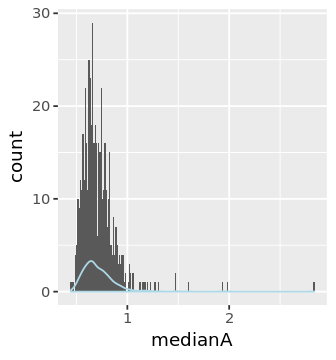

In [5]:
options(repr.plot.width=2.8, repr.plot.height=3)
A %>% ggplot(aes(medianA)) + geom_histogram(bins = 200) +geom_density(color = "lightblue")
summary(A$medianA)

In [6]:
A %>% head()

RNA_id          Pseudotime cluster_replace medianA   castA     musA     
1 Day_0_Xi_Mus_10 2.103427   0               0.5039790 0.2722565 0.1894758
2 Day_0_Xi_Mus_12 1.144572   0               0.6122761 0.3938263 0.3089411
3 Day_0_Xi_Mus_13 2.080060   0               0.6516088 0.3779655 0.2671286
4 Day_0_Xi_Mus_14 1.442099   0               0.6938730 0.4059490 0.2880450
5 Day_0_Xi_Mus_15 1.278847   0               1.3143148 0.8591275 0.8591275
6 Day_0_Xi_Mus_16 1.163546   0               0.5528124 0.2837191 0.2199744

In [7]:
allelic_wAuto <- allelic %>% left_join(A[,c("RNA_id","medianA")], by = "RNA_id") %>% mutate(Mus_Auto_ratio = mus_norm/medianA, Cast_Auto_ratio = cast_norm/medianA)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


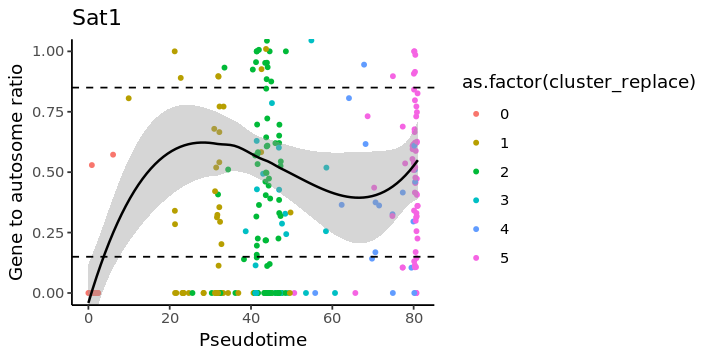

In [11]:
options(repr.plot.width=6, repr.plot.height=3)
allelic_wAuto %>% filter(gene=="Sat1") %>% filter(sum_norm > 0) %>%
            ggplot(aes(Pseudotime, Mus_Auto_ratio)) +
                geom_point(size = 1, alpha = 1, aes(color = as.factor(cluster_replace))) +
                geom_smooth(color = "black", size = .7) +                                                     
                geom_hline(yintercept = c(0.15, 0.85), linetype = 'dashed', size = .5) +
                                                     coord_cartesian(ylim = c(0,1))+
               ylab("Gene to autosome ratio")+
                ggtitle("Sat1") +
                theme_classic()   

In [13]:
plots <- list()

genes <- consistent_cluster$gene

for(i in seq(genes)){

plots[[i]] <- allelic_wAuto %>% filter(sum_norm > 0) %>%
        filter(gene == genes[i]) %>%                   
            ggplot(aes(Pseudotime, Mus_Auto_ratio)) +
                geom_point(size = 1, alpha = 1, aes(color = as.factor(cluster_replace))) +
                geom_smooth(color = "black", size = .7) +                                                     
                geom_hline(yintercept = c(0.15, 0.85), linetype = 'dashed', size = .5) +
                                                     coord_cartesian(ylim = c(0,1))+
                ggtitle(paste0(genes[i])) +
                theme_classic()   +
                theme(legend.position = "none") 
}


plots <- CombinePlots(plots = plots, ncol=4)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ 

In [14]:
pdf("allele_specific/XCR/AJ_0065.9_Cluster_consist_genes_Mus_auto_ratio.pdf", width=13, height=50)
plot(plots)
dev.off()

png 
  2

In [27]:
# Calculate fitted lines for all cluster consistent X-linked genes

library(purrr)

allelic_fit_chrX_clust_cons_wAuto <- allelic_wAuto %>% filter(sum_norm > 0) %>% filter(gene %in% consistent_cluster$gene) %>%
                                group_split(gene) %>%
                                map(~fit_n_add(data = .,
                                               y = .$Mus_Auto_ratio,
                                               x = .$Pseudotime,
                                               gene = .$gene[1],
                                               range = 2:80)) %>%
                                bind_rows() 

Warning message in bind_rows_(x, .id):
"Unequal factor levels: coercing to character"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding cha

In [28]:
allelic_fit_chrX_clust_cons_wAuto %>% head()

gene          pseudotime fitted_data
1 1110012L19Rik 2          0.008133839
2 1110012L19Rik 3          0.006907498
3 1110012L19Rik 4          0.005700261
4 1110012L19Rik 5          0.004518646
5 1110012L19Rik 6          0.003369173
6 1110012L19Rik 7          0.002258362

In [29]:
# K-means clustering based on fitted trends
library(tibble)
allelic_fit_chrX_clust_cons_mtx <- allelic_fit_chrX_clust_cons_wAuto %>% filter(gene != "Xist") %>% spread(pseudotime, fitted_data) %>% column_to_rownames("gene")

# Compute k-means with k = 6
set.seed(123)
km.res.fit <- kmeans(allelic_fit_chrX_clust_cons_mtx, 6,iter.max = 100, nstart = 100)

allelic_fit_kmeans <- cbind(allelic_fit_chrX_clust_cons_mtx, k_means_cluster = km.res.fit$cluster) %>% 
                                as.data.frame() %>%
                                rownames_to_column("gene")

allelic_fit_kmeans_long <- allelic_fit_kmeans %>%
                                    gather(pseudotime, fitted_data,-gene, -k_means_cluster) 

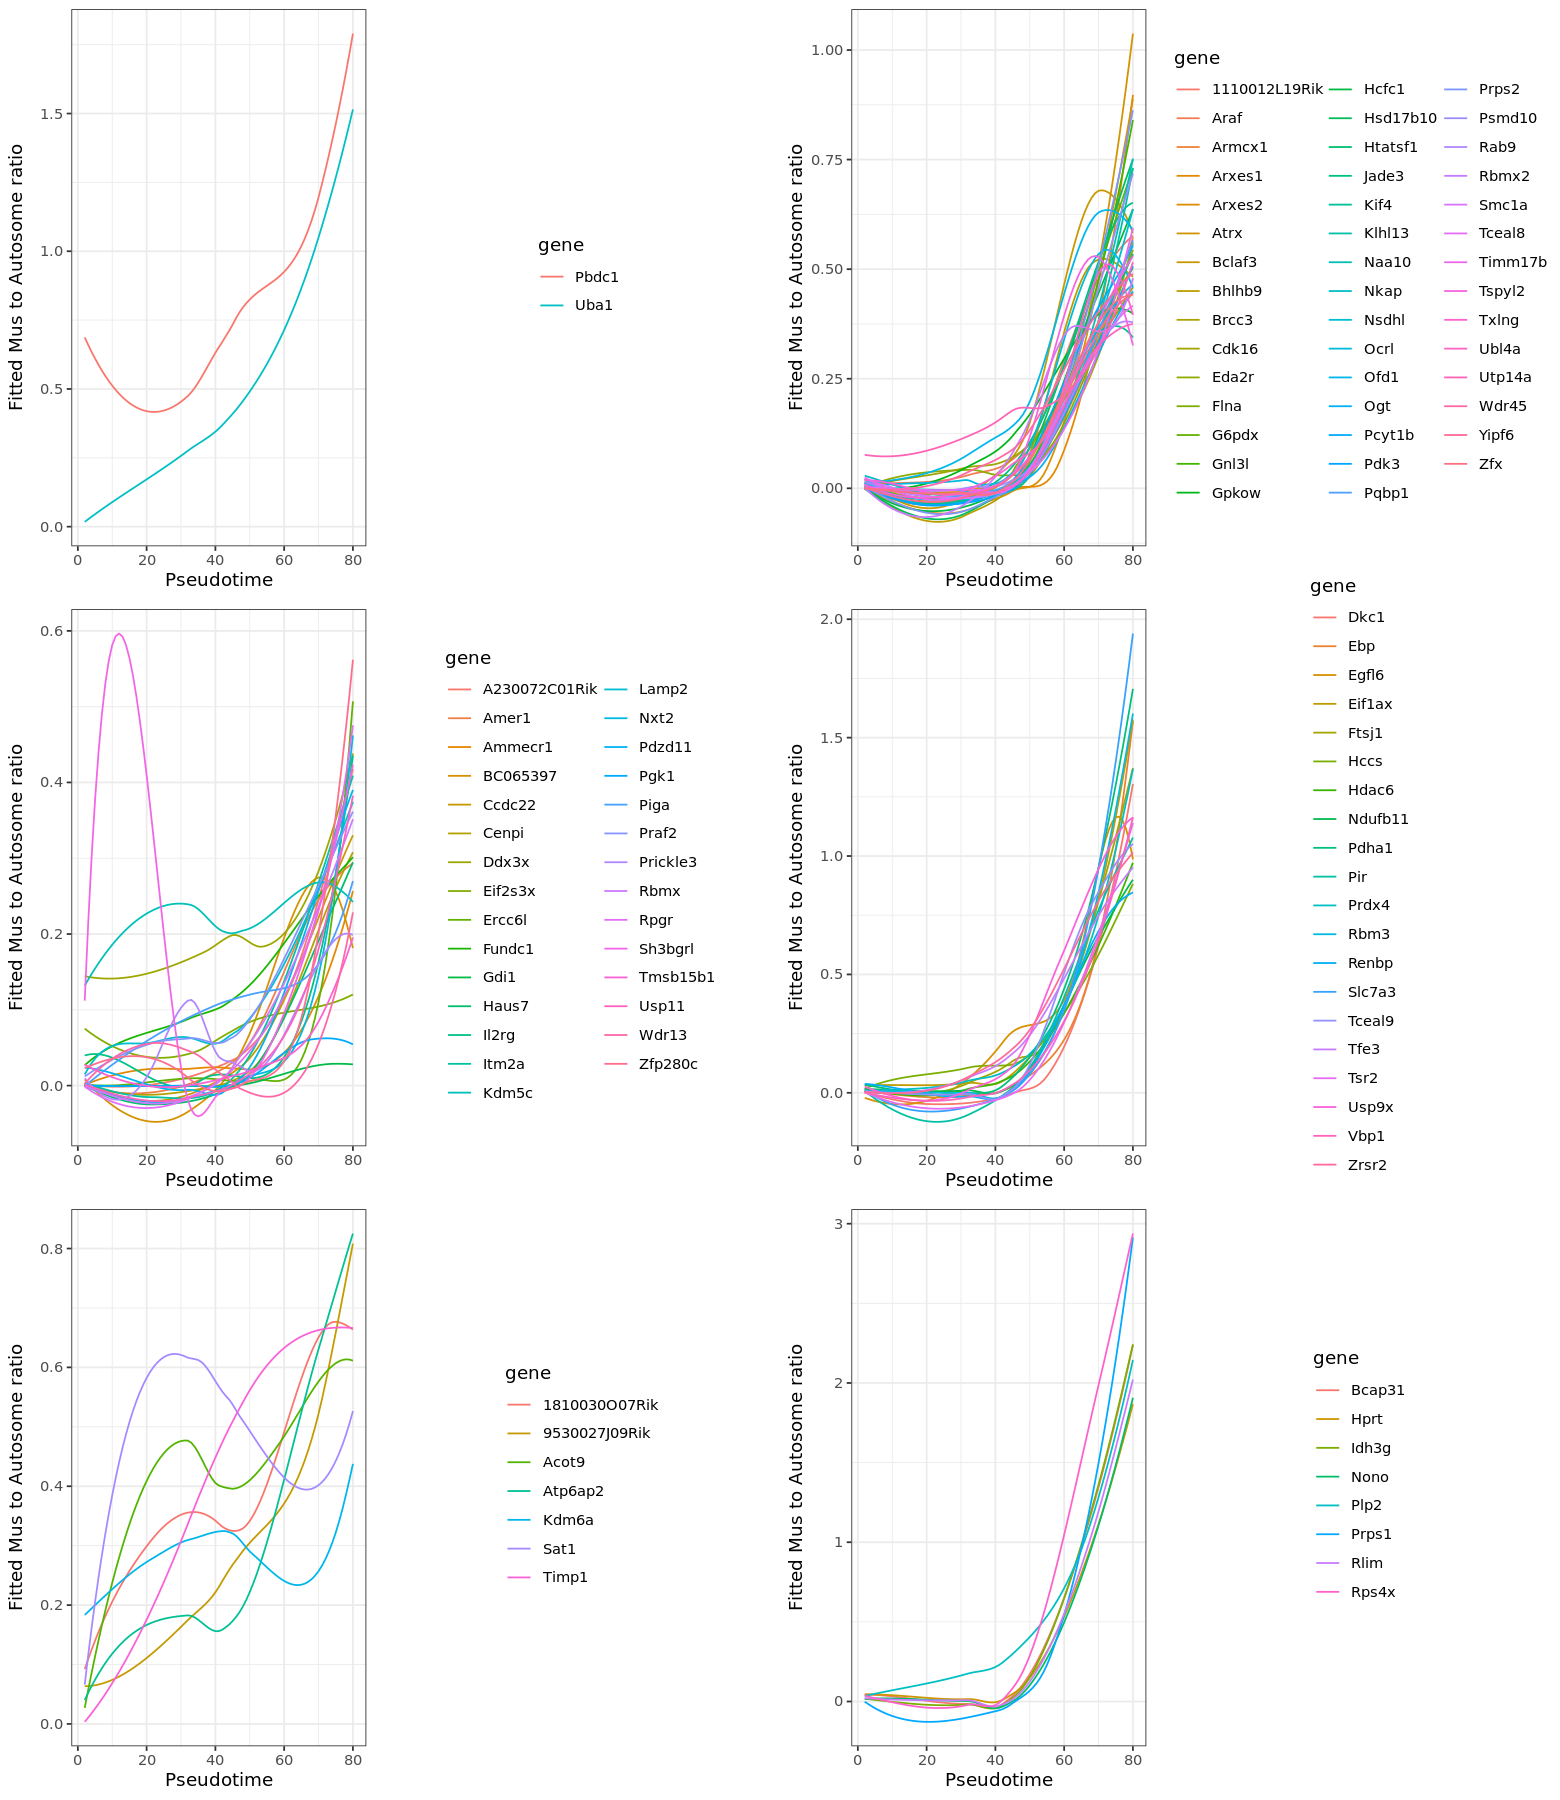

In [30]:
# Visualize clustered fitted models

kinetics_k_fit_plots <- list()

for (i in seq(unique(allelic_fit_kmeans_long$k_means_cluster))){
    
kinetics_k_fit_plots[[i]] <- allelic_fit_kmeans_long %>% filter(k_means_cluster == i) %>%
                            ggplot(aes(as.integer(pseudotime), fitted_data, group = gene, color = gene)) +
                                geom_line() +
                                #geom_hline(yintercept = c(0.15, 0.85), linetype = 'dashed', size = .5) +
                                                                             #coord_cartesian(ylim = c(0,1))+
                                ylab("Fitted Mus to Autosome ratio")+
                                xlab("Pseudotime") +
                                theme_bw()
                                
    }

options(repr.plot.width=13, repr.plot.height=15)
CombinePlots(plots = kinetics_k_fit_plots, ncol=2)

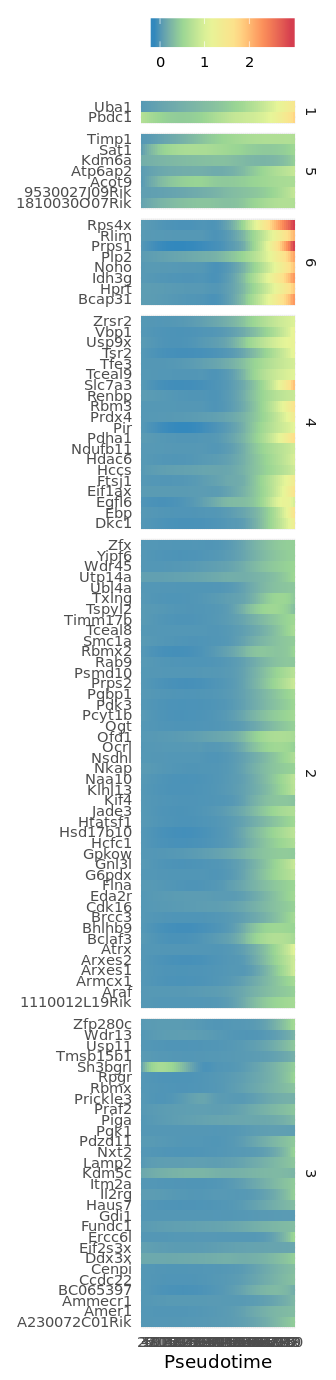

In [33]:
options(repr.plot.width=2.8, repr.plot.height=11.5)

allelic_fit_kmeans_long$pseudotime_fct <- factor(allelic_fit_kmeans_long$pseudotime, levels = sort(unique(as.integer(allelic_fit_kmeans_long$pseudotime))))
allelic_fit_kmeans_long$k_means_cluster <- factor(allelic_fit_kmeans_long$k_means_cluster, levels = c(1,5,6,4,2,3))

allelic_fit_kmeans_long %>% 
            ggplot(aes(x = pseudotime_fct, y = gene, fill = fitted_data)) +
                geom_tile() +
                facet_grid(k_means_cluster ~ ., scales = 'free', space = 'free_y') +
                #facet_wrap(. ~ k_means_cluster, scales="free_y", ncol = 1, strip.position = "right") +
                scale_fill_distiller(palette = "Spectral") +
                labs(x="Pseudotime", fill = "") +
                
                theme_minimal()  +
                theme(legend.position = "top") +
                #theme(axis.text.y=element_blank()) +
                #theme(strip.background = element_blank(),
                #  strip.text.y = element_blank()) +
                #theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
                theme(axis.title.y = element_blank())